In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "uni90"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 326
Categorical features: 10
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 398
Categorical Columns: 10


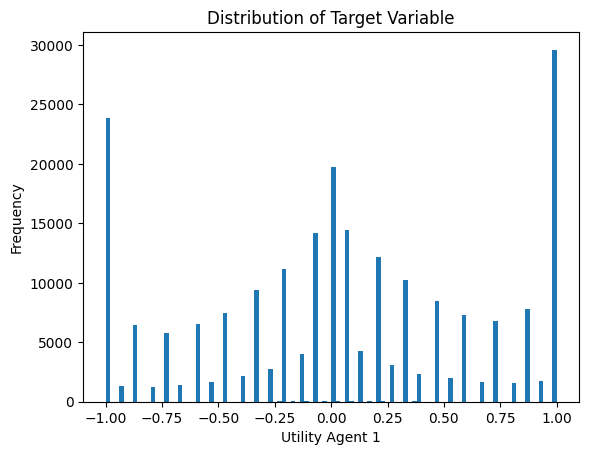

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6115048	test: 0.5461447	best: 0.5461447 (0)	total: 162ms	remaining: 8m 6s


50:	learn: 0.3802161	test: 0.4598838	best: 0.4598838 (50)	total: 5.12s	remaining: 4m 56s


100:	learn: 0.3427388	test: 0.4442185	best: 0.4442185 (100)	total: 10.3s	remaining: 4m 54s


150:	learn: 0.3193477	test: 0.4352227	best: 0.4352227 (150)	total: 15.3s	remaining: 4m 49s


200:	learn: 0.3039994	test: 0.4306796	best: 0.4306796 (200)	total: 20.3s	remaining: 4m 42s


250:	learn: 0.2919526	test: 0.4270324	best: 0.4270324 (250)	total: 25.3s	remaining: 4m 37s


300:	learn: 0.2830930	test: 0.4258136	best: 0.4258136 (300)	total: 30.4s	remaining: 4m 32s


350:	learn: 0.2749233	test: 0.4240913	best: 0.4240913 (350)	total: 35.6s	remaining: 4m 28s


400:	learn: 0.2673467	test: 0.4230005	best: 0.4229336 (394)	total: 40.8s	remaining: 4m 24s


450:	learn: 0.2622800	test: 0.4222298	best: 0.4222298 (450)	total: 46s	remaining: 4m 20s


500:	learn: 0.2565329	test: 0.4210769	best: 0.4210769 (500)	total: 51.1s	remaining: 4m 15s


550:	learn: 0.2514218	test: 0.4204184	best: 0.4203748 (546)	total: 56.2s	remaining: 4m 9s


600:	learn: 0.2472394	test: 0.4196528	best: 0.4196528 (600)	total: 1m 1s	remaining: 4m 5s


650:	learn: 0.2432785	test: 0.4193512	best: 0.4192907 (642)	total: 1m 6s	remaining: 3m 59s


700:	learn: 0.2393113	test: 0.4190894	best: 0.4190434 (686)	total: 1m 11s	remaining: 3m 55s


750:	learn: 0.2357455	test: 0.4184373	best: 0.4184214 (749)	total: 1m 17s	remaining: 3m 50s


800:	learn: 0.2325346	test: 0.4183459	best: 0.4182800 (782)	total: 1m 22s	remaining: 3m 45s


850:	learn: 0.2297234	test: 0.4179508	best: 0.4179508 (850)	total: 1m 27s	remaining: 3m 40s


900:	learn: 0.2269912	test: 0.4177191	best: 0.4177191 (900)	total: 1m 32s	remaining: 3m 35s


950:	learn: 0.2240213	test: 0.4175483	best: 0.4175468 (949)	total: 1m 37s	remaining: 3m 30s


1000:	learn: 0.2212803	test: 0.4173746	best: 0.4173727 (999)	total: 1m 43s	remaining: 3m 25s


1050:	learn: 0.2189176	test: 0.4172653	best: 0.4172459 (1031)	total: 1m 48s	remaining: 3m 20s


1100:	learn: 0.2164441	test: 0.4172089	best: 0.4171878 (1091)	total: 1m 53s	remaining: 3m 15s


1150:	learn: 0.2142728	test: 0.4170340	best: 0.4170217 (1149)	total: 1m 58s	remaining: 3m 11s


1200:	learn: 0.2121144	test: 0.4169783	best: 0.4169783 (1200)	total: 2m 4s	remaining: 3m 5s


1250:	learn: 0.2098993	test: 0.4168095	best: 0.4167967 (1248)	total: 2m 9s	remaining: 3m


1300:	learn: 0.2079569	test: 0.4167336	best: 0.4167159 (1296)	total: 2m 14s	remaining: 2m 55s


1350:	learn: 0.2060471	test: 0.4165927	best: 0.4165309 (1328)	total: 2m 19s	remaining: 2m 50s


1400:	learn: 0.2042586	test: 0.4164500	best: 0.4164500 (1400)	total: 2m 24s	remaining: 2m 44s


1450:	learn: 0.2024225	test: 0.4163301	best: 0.4163301 (1450)	total: 2m 29s	remaining: 2m 39s


1500:	learn: 0.2007562	test: 0.4162781	best: 0.4162455 (1487)	total: 2m 35s	remaining: 2m 34s


1550:	learn: 0.1990514	test: 0.4161799	best: 0.4161799 (1549)	total: 2m 40s	remaining: 2m 29s


1600:	learn: 0.1974515	test: 0.4161064	best: 0.4161064 (1600)	total: 2m 45s	remaining: 2m 24s


1650:	learn: 0.1957385	test: 0.4161142	best: 0.4160733 (1639)	total: 2m 50s	remaining: 2m 19s


1700:	learn: 0.1940399	test: 0.4161025	best: 0.4160498 (1665)	total: 2m 55s	remaining: 2m 14s


1750:	learn: 0.1923899	test: 0.4160528	best: 0.4160398 (1746)	total: 3m	remaining: 2m 8s


1800:	learn: 0.1908680	test: 0.4160346	best: 0.4160326 (1752)	total: 3m 5s	remaining: 2m 3s


1850:	learn: 0.1894018	test: 0.4159928	best: 0.4159875 (1849)	total: 3m 11s	remaining: 1m 58s


1900:	learn: 0.1880022	test: 0.4160129	best: 0.4159795 (1866)	total: 3m 16s	remaining: 1m 53s


1950:	learn: 0.1865743	test: 0.4160754	best: 0.4159795 (1866)	total: 3m 21s	remaining: 1m 48s


2000:	learn: 0.1851388	test: 0.4160608	best: 0.4159795 (1866)	total: 3m 26s	remaining: 1m 43s


2050:	learn: 0.1835887	test: 0.4160062	best: 0.4159795 (1866)	total: 3m 32s	remaining: 1m 38s


2100:	learn: 0.1821895	test: 0.4159689	best: 0.4159495 (2085)	total: 3m 37s	remaining: 1m 32s


2150:	learn: 0.1809373	test: 0.4159513	best: 0.4159377 (2147)	total: 3m 42s	remaining: 1m 27s


2200:	learn: 0.1796145	test: 0.4160567	best: 0.4159377 (2147)	total: 3m 47s	remaining: 1m 22s


2250:	learn: 0.1783396	test: 0.4159842	best: 0.4159377 (2147)	total: 3m 52s	remaining: 1m 17s


2300:	learn: 0.1772061	test: 0.4159690	best: 0.4159377 (2147)	total: 3m 58s	remaining: 1m 12s


2350:	learn: 0.1759077	test: 0.4159498	best: 0.4159375 (2312)	total: 4m 3s	remaining: 1m 7s


2400:	learn: 0.1746507	test: 0.4159692	best: 0.4159375 (2312)	total: 4m 8s	remaining: 1m 2s


2450:	learn: 0.1735461	test: 0.4159462	best: 0.4159375 (2312)	total: 4m 13s	remaining: 56.9s


2500:	learn: 0.1723656	test: 0.4159756	best: 0.4159339 (2479)	total: 4m 19s	remaining: 51.7s


2550:	learn: 0.1710494	test: 0.4160325	best: 0.4159339 (2479)	total: 4m 24s	remaining: 46.6s


2600:	learn: 0.1697037	test: 0.4160648	best: 0.4159339 (2479)	total: 4m 29s	remaining: 41.4s


2650:	learn: 0.1685731	test: 0.4160380	best: 0.4159339 (2479)	total: 4m 35s	remaining: 36.2s


2700:	learn: 0.1674771	test: 0.4160766	best: 0.4159339 (2479)	total: 4m 40s	remaining: 31.1s


2750:	learn: 0.1663507	test: 0.4161180	best: 0.4159339 (2479)	total: 4m 45s	remaining: 25.9s


2800:	learn: 0.1652732	test: 0.4161721	best: 0.4159339 (2479)	total: 4m 51s	remaining: 20.7s


2850:	learn: 0.1641928	test: 0.4161917	best: 0.4159339 (2479)	total: 4m 56s	remaining: 15.5s


2900:	learn: 0.1630797	test: 0.4161967	best: 0.4159339 (2479)	total: 5m 1s	remaining: 10.3s


2950:	learn: 0.1620353	test: 0.4162246	best: 0.4159339 (2479)	total: 5m 7s	remaining: 5.1s


2999:	learn: 0.1610753	test: 0.4162463	best: 0.4159339 (2479)	total: 5m 12s	remaining: 0us

bestTest = 0.4159338864
bestIteration = 2479

Shrink model to first 2480 iterations.


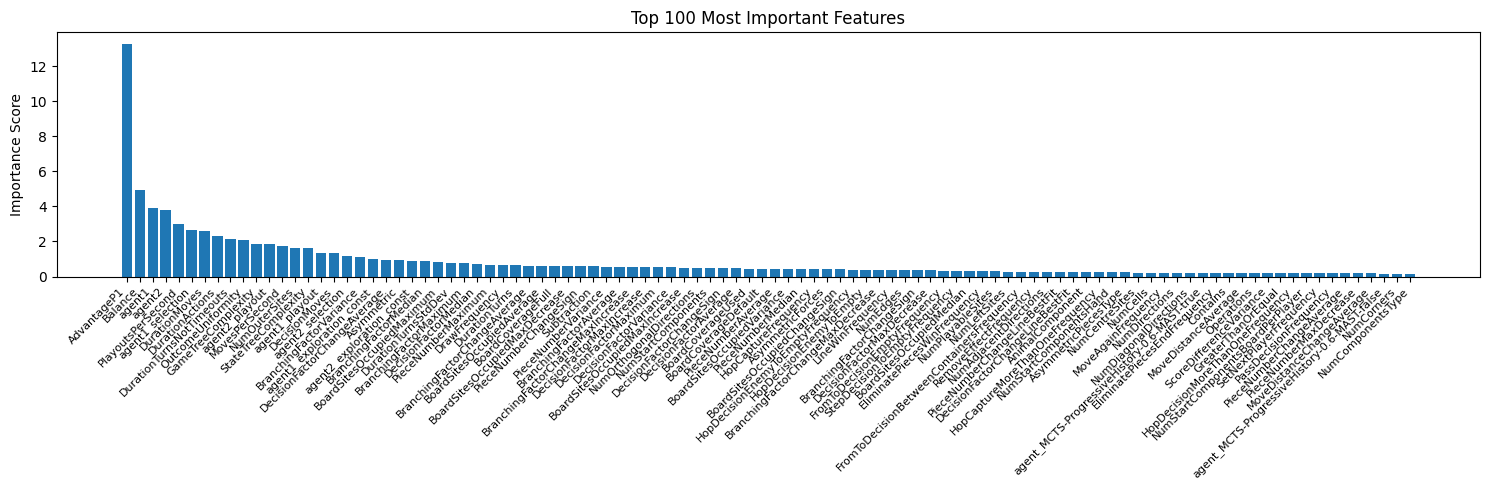

Fold 1 - RMSE: 0.41556281529000255
Fold 2


0:	learn: 0.6058072	test: 0.5788168	best: 0.5788168 (0)	total: 101ms	remaining: 5m 1s


50:	learn: 0.3912341	test: 0.4800692	best: 0.4800692 (50)	total: 5.11s	remaining: 4m 55s


100:	learn: 0.3507086	test: 0.4634053	best: 0.4634053 (100)	total: 10.4s	remaining: 4m 57s


150:	learn: 0.3252856	test: 0.4561564	best: 0.4561564 (150)	total: 15.7s	remaining: 4m 55s


200:	learn: 0.3097310	test: 0.4535262	best: 0.4534558 (193)	total: 21s	remaining: 4m 52s


250:	learn: 0.2983422	test: 0.4521800	best: 0.4521547 (247)	total: 26.2s	remaining: 4m 47s


300:	learn: 0.2896665	test: 0.4507121	best: 0.4507121 (300)	total: 31.4s	remaining: 4m 41s


350:	learn: 0.2813069	test: 0.4500202	best: 0.4500202 (350)	total: 36.8s	remaining: 4m 37s


400:	learn: 0.2741015	test: 0.4493808	best: 0.4493190 (392)	total: 42.1s	remaining: 4m 32s


450:	learn: 0.2679918	test: 0.4483040	best: 0.4483040 (450)	total: 47.4s	remaining: 4m 28s


500:	learn: 0.2624631	test: 0.4476606	best: 0.4476432 (498)	total: 52.9s	remaining: 4m 23s


550:	learn: 0.2578685	test: 0.4473834	best: 0.4473834 (550)	total: 58.2s	remaining: 4m 18s


600:	learn: 0.2535269	test: 0.4472040	best: 0.4471155 (598)	total: 1m 3s	remaining: 4m 13s


650:	learn: 0.2494353	test: 0.4470978	best: 0.4469358 (623)	total: 1m 8s	remaining: 4m 8s


700:	learn: 0.2454714	test: 0.4465970	best: 0.4465970 (700)	total: 1m 14s	remaining: 4m 3s


750:	learn: 0.2418446	test: 0.4461208	best: 0.4461031 (743)	total: 1m 19s	remaining: 3m 58s


800:	learn: 0.2385317	test: 0.4460375	best: 0.4459922 (795)	total: 1m 25s	remaining: 3m 53s


850:	learn: 0.2355874	test: 0.4457852	best: 0.4457454 (842)	total: 1m 30s	remaining: 3m 48s


900:	learn: 0.2327996	test: 0.4453957	best: 0.4453878 (899)	total: 1m 35s	remaining: 3m 43s


950:	learn: 0.2302974	test: 0.4451359	best: 0.4451154 (944)	total: 1m 41s	remaining: 3m 38s


1000:	learn: 0.2278397	test: 0.4451374	best: 0.4450764 (959)	total: 1m 46s	remaining: 3m 33s


1050:	learn: 0.2254750	test: 0.4449261	best: 0.4449261 (1050)	total: 1m 52s	remaining: 3m 28s


1100:	learn: 0.2233348	test: 0.4446577	best: 0.4446540 (1099)	total: 1m 57s	remaining: 3m 22s


1150:	learn: 0.2210276	test: 0.4446692	best: 0.4446478 (1102)	total: 2m 3s	remaining: 3m 17s


1200:	learn: 0.2187472	test: 0.4443996	best: 0.4443617 (1196)	total: 2m 8s	remaining: 3m 12s


1250:	learn: 0.2163590	test: 0.4443576	best: 0.4443329 (1217)	total: 2m 13s	remaining: 3m 6s


1300:	learn: 0.2144997	test: 0.4442782	best: 0.4442749 (1288)	total: 2m 19s	remaining: 3m 1s


1350:	learn: 0.2125137	test: 0.4441556	best: 0.4441105 (1344)	total: 2m 24s	remaining: 2m 56s


1400:	learn: 0.2105462	test: 0.4441571	best: 0.4441105 (1344)	total: 2m 30s	remaining: 2m 51s


1450:	learn: 0.2086643	test: 0.4441626	best: 0.4441037 (1427)	total: 2m 35s	remaining: 2m 45s


1500:	learn: 0.2070536	test: 0.4440614	best: 0.4440614 (1500)	total: 2m 41s	remaining: 2m 40s


1550:	learn: 0.2052238	test: 0.4440360	best: 0.4440360 (1550)	total: 2m 46s	remaining: 2m 35s


1600:	learn: 0.2035241	test: 0.4440086	best: 0.4439894 (1596)	total: 2m 52s	remaining: 2m 30s


1650:	learn: 0.2018538	test: 0.4440112	best: 0.4439416 (1612)	total: 2m 57s	remaining: 2m 25s


1700:	learn: 0.2003182	test: 0.4439279	best: 0.4439156 (1698)	total: 3m 3s	remaining: 2m 19s


1750:	learn: 0.1986344	test: 0.4438106	best: 0.4437932 (1743)	total: 3m 8s	remaining: 2m 14s


1800:	learn: 0.1972074	test: 0.4437686	best: 0.4437598 (1782)	total: 3m 14s	remaining: 2m 9s


1850:	learn: 0.1957070	test: 0.4437537	best: 0.4437184 (1843)	total: 3m 20s	remaining: 2m 4s


1900:	learn: 0.1941123	test: 0.4438027	best: 0.4437184 (1843)	total: 3m 25s	remaining: 1m 58s


1950:	learn: 0.1926284	test: 0.4436526	best: 0.4436364 (1940)	total: 3m 31s	remaining: 1m 53s


2000:	learn: 0.1912668	test: 0.4437479	best: 0.4436364 (1940)	total: 3m 36s	remaining: 1m 48s


2050:	learn: 0.1899468	test: 0.4437181	best: 0.4436364 (1940)	total: 3m 42s	remaining: 1m 43s


2100:	learn: 0.1885499	test: 0.4436872	best: 0.4436364 (1940)	total: 3m 48s	remaining: 1m 37s


2150:	learn: 0.1871668	test: 0.4436646	best: 0.4436237 (2118)	total: 3m 53s	remaining: 1m 32s


2200:	learn: 0.1859093	test: 0.4436221	best: 0.4436059 (2173)	total: 3m 59s	remaining: 1m 26s


2250:	learn: 0.1847129	test: 0.4436162	best: 0.4435897 (2236)	total: 4m 5s	remaining: 1m 21s


2300:	learn: 0.1834311	test: 0.4435392	best: 0.4434956 (2281)	total: 4m 11s	remaining: 1m 16s


2350:	learn: 0.1821497	test: 0.4434398	best: 0.4434359 (2348)	total: 4m 16s	remaining: 1m 10s


2400:	learn: 0.1809731	test: 0.4434122	best: 0.4434007 (2394)	total: 4m 22s	remaining: 1m 5s


2450:	learn: 0.1798876	test: 0.4433521	best: 0.4433454 (2440)	total: 4m 28s	remaining: 1m


2500:	learn: 0.1786218	test: 0.4432931	best: 0.4432823 (2496)	total: 4m 34s	remaining: 54.7s


2550:	learn: 0.1774245	test: 0.4432793	best: 0.4432484 (2527)	total: 4m 39s	remaining: 49.3s


2600:	learn: 0.1762527	test: 0.4433084	best: 0.4432484 (2527)	total: 4m 45s	remaining: 43.8s


2650:	learn: 0.1751983	test: 0.4432541	best: 0.4432484 (2527)	total: 4m 51s	remaining: 38.4s


2700:	learn: 0.1740990	test: 0.4432379	best: 0.4432050 (2673)	total: 4m 57s	remaining: 32.9s


2750:	learn: 0.1730233	test: 0.4432615	best: 0.4432050 (2673)	total: 5m 3s	remaining: 27.4s


2800:	learn: 0.1719952	test: 0.4432108	best: 0.4431860 (2785)	total: 5m 9s	remaining: 22s


2850:	learn: 0.1709182	test: 0.4431636	best: 0.4431594 (2849)	total: 5m 15s	remaining: 16.5s


2900:	learn: 0.1698293	test: 0.4431214	best: 0.4431185 (2895)	total: 5m 21s	remaining: 11s


2950:	learn: 0.1687447	test: 0.4431547	best: 0.4431120 (2905)	total: 5m 26s	remaining: 5.43s


2999:	learn: 0.1677811	test: 0.4431764	best: 0.4431120 (2905)	total: 5m 32s	remaining: 0us

bestTest = 0.4431120107
bestIteration = 2905

Shrink model to first 2906 iterations.


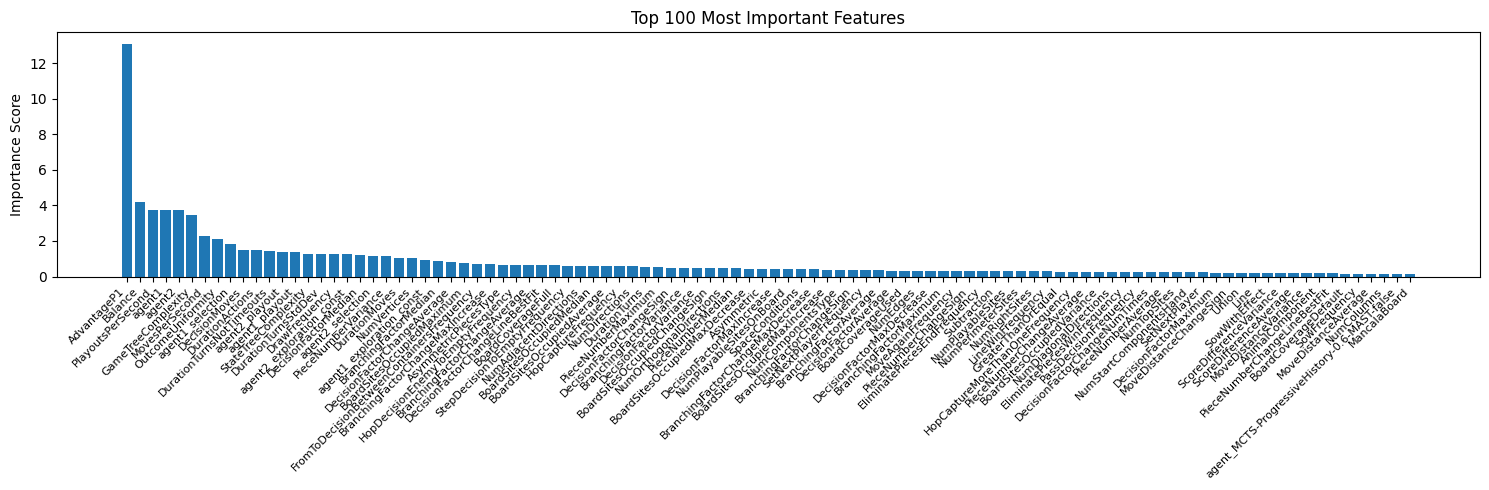

Fold 2 - RMSE: 0.4426060145876793
Fold 3


0:	learn: 0.6019304	test: 0.5983760	best: 0.5983760 (0)	total: 96ms	remaining: 4m 47s


50:	learn: 0.3855126	test: 0.4623933	best: 0.4623933 (50)	total: 5.48s	remaining: 5m 17s


100:	learn: 0.3524326	test: 0.4479233	best: 0.4479233 (100)	total: 11.3s	remaining: 5m 24s


150:	learn: 0.3279084	test: 0.4403112	best: 0.4403112 (150)	total: 16.9s	remaining: 5m 18s


200:	learn: 0.3116612	test: 0.4372192	best: 0.4372192 (200)	total: 22.4s	remaining: 5m 11s


250:	learn: 0.2994509	test: 0.4348974	best: 0.4348450 (247)	total: 28s	remaining: 5m 6s


300:	learn: 0.2897644	test: 0.4322274	best: 0.4322274 (300)	total: 33.6s	remaining: 5m 1s


350:	learn: 0.2819549	test: 0.4309605	best: 0.4309605 (350)	total: 39.3s	remaining: 4m 56s


400:	learn: 0.2750680	test: 0.4297691	best: 0.4297531 (396)	total: 44.8s	remaining: 4m 50s


450:	learn: 0.2690020	test: 0.4295397	best: 0.4295299 (448)	total: 50.4s	remaining: 4m 45s


500:	learn: 0.2636477	test: 0.4290174	best: 0.4290174 (500)	total: 56s	remaining: 4m 39s


550:	learn: 0.2584303	test: 0.4284293	best: 0.4284293 (550)	total: 1m 1s	remaining: 4m 34s


600:	learn: 0.2541525	test: 0.4280240	best: 0.4280048 (597)	total: 1m 7s	remaining: 4m 29s


650:	learn: 0.2499948	test: 0.4277498	best: 0.4277139 (636)	total: 1m 13s	remaining: 4m 23s


700:	learn: 0.2460736	test: 0.4273576	best: 0.4273576 (700)	total: 1m 18s	remaining: 4m 17s


750:	learn: 0.2424720	test: 0.4272378	best: 0.4272350 (732)	total: 1m 24s	remaining: 4m 12s


800:	learn: 0.2393478	test: 0.4270187	best: 0.4269318 (779)	total: 1m 29s	remaining: 4m 6s


850:	learn: 0.2365118	test: 0.4268724	best: 0.4268724 (850)	total: 1m 35s	remaining: 4m 1s


900:	learn: 0.2336581	test: 0.4267502	best: 0.4267502 (900)	total: 1m 41s	remaining: 3m 55s


950:	learn: 0.2311279	test: 0.4268133	best: 0.4267502 (900)	total: 1m 46s	remaining: 3m 49s


1000:	learn: 0.2285914	test: 0.4265601	best: 0.4265601 (1000)	total: 1m 52s	remaining: 3m 44s


1050:	learn: 0.2259134	test: 0.4261804	best: 0.4261804 (1050)	total: 1m 57s	remaining: 3m 38s


1100:	learn: 0.2235171	test: 0.4260243	best: 0.4259954 (1094)	total: 2m 3s	remaining: 3m 32s


1150:	learn: 0.2212210	test: 0.4258412	best: 0.4258099 (1142)	total: 2m 8s	remaining: 3m 27s


1200:	learn: 0.2190670	test: 0.4256834	best: 0.4256834 (1200)	total: 2m 14s	remaining: 3m 21s


1250:	learn: 0.2168030	test: 0.4255220	best: 0.4255052 (1244)	total: 2m 20s	remaining: 3m 16s


1300:	learn: 0.2146884	test: 0.4254378	best: 0.4254378 (1300)	total: 2m 25s	remaining: 3m 10s


1350:	learn: 0.2126561	test: 0.4254038	best: 0.4253544 (1341)	total: 2m 31s	remaining: 3m 4s


1400:	learn: 0.2108104	test: 0.4253688	best: 0.4253308 (1371)	total: 2m 36s	remaining: 2m 58s


1450:	learn: 0.2090085	test: 0.4252673	best: 0.4252630 (1448)	total: 2m 42s	remaining: 2m 53s


1500:	learn: 0.2072046	test: 0.4252047	best: 0.4251388 (1492)	total: 2m 48s	remaining: 2m 47s


1550:	learn: 0.2053860	test: 0.4250852	best: 0.4250852 (1550)	total: 2m 53s	remaining: 2m 42s


1600:	learn: 0.2035353	test: 0.4250871	best: 0.4250731 (1562)	total: 2m 59s	remaining: 2m 36s


1650:	learn: 0.2019404	test: 0.4251566	best: 0.4250662 (1605)	total: 3m 4s	remaining: 2m 30s


1700:	learn: 0.2001447	test: 0.4251676	best: 0.4250662 (1605)	total: 3m 10s	remaining: 2m 25s


1750:	learn: 0.1984525	test: 0.4250658	best: 0.4250617 (1749)	total: 3m 15s	remaining: 2m 19s


1800:	learn: 0.1967434	test: 0.4250036	best: 0.4249740 (1788)	total: 3m 21s	remaining: 2m 14s


1850:	learn: 0.1950387	test: 0.4250270	best: 0.4249732 (1814)	total: 3m 26s	remaining: 2m 8s


1900:	learn: 0.1933987	test: 0.4250650	best: 0.4249732 (1814)	total: 3m 32s	remaining: 2m 2s


1950:	learn: 0.1919679	test: 0.4250236	best: 0.4249732 (1814)	total: 3m 37s	remaining: 1m 57s


2000:	learn: 0.1904356	test: 0.4250209	best: 0.4249732 (1814)	total: 3m 43s	remaining: 1m 51s


2050:	learn: 0.1890614	test: 0.4249696	best: 0.4249661 (2046)	total: 3m 48s	remaining: 1m 45s


2100:	learn: 0.1877784	test: 0.4249753	best: 0.4249227 (2072)	total: 3m 54s	remaining: 1m 40s


2150:	learn: 0.1863965	test: 0.4250760	best: 0.4249227 (2072)	total: 4m	remaining: 1m 34s


2200:	learn: 0.1850344	test: 0.4250009	best: 0.4249227 (2072)	total: 4m 5s	remaining: 1m 29s


2250:	learn: 0.1837508	test: 0.4250133	best: 0.4249227 (2072)	total: 4m 11s	remaining: 1m 23s


2300:	learn: 0.1824593	test: 0.4249399	best: 0.4249059 (2290)	total: 4m 16s	remaining: 1m 17s


2350:	learn: 0.1811462	test: 0.4248805	best: 0.4248805 (2350)	total: 4m 22s	remaining: 1m 12s


2400:	learn: 0.1797837	test: 0.4248798	best: 0.4248333 (2370)	total: 4m 27s	remaining: 1m 6s


2450:	learn: 0.1785845	test: 0.4248362	best: 0.4248294 (2445)	total: 4m 33s	remaining: 1m 1s


2500:	learn: 0.1773256	test: 0.4248280	best: 0.4247895 (2474)	total: 4m 38s	remaining: 55.6s


2550:	learn: 0.1761225	test: 0.4248281	best: 0.4247895 (2474)	total: 4m 44s	remaining: 50s


2600:	learn: 0.1748636	test: 0.4248074	best: 0.4247895 (2474)	total: 4m 49s	remaining: 44.4s


2650:	learn: 0.1736899	test: 0.4248222	best: 0.4247895 (2474)	total: 4m 55s	remaining: 38.9s


2700:	learn: 0.1725440	test: 0.4247537	best: 0.4247324 (2661)	total: 5m	remaining: 33.3s


2750:	learn: 0.1714597	test: 0.4247725	best: 0.4247324 (2661)	total: 5m 6s	remaining: 27.7s


2800:	learn: 0.1703861	test: 0.4247823	best: 0.4247324 (2661)	total: 5m 12s	remaining: 22.2s


2850:	learn: 0.1693259	test: 0.4248974	best: 0.4247324 (2661)	total: 5m 17s	remaining: 16.6s


2900:	learn: 0.1681798	test: 0.4248909	best: 0.4247324 (2661)	total: 5m 23s	remaining: 11s


2950:	learn: 0.1670304	test: 0.4249266	best: 0.4247324 (2661)	total: 5m 28s	remaining: 5.46s


2999:	learn: 0.1660141	test: 0.4249301	best: 0.4247324 (2661)	total: 5m 34s	remaining: 0us

bestTest = 0.4247323943
bestIteration = 2661

Shrink model to first 2662 iterations.


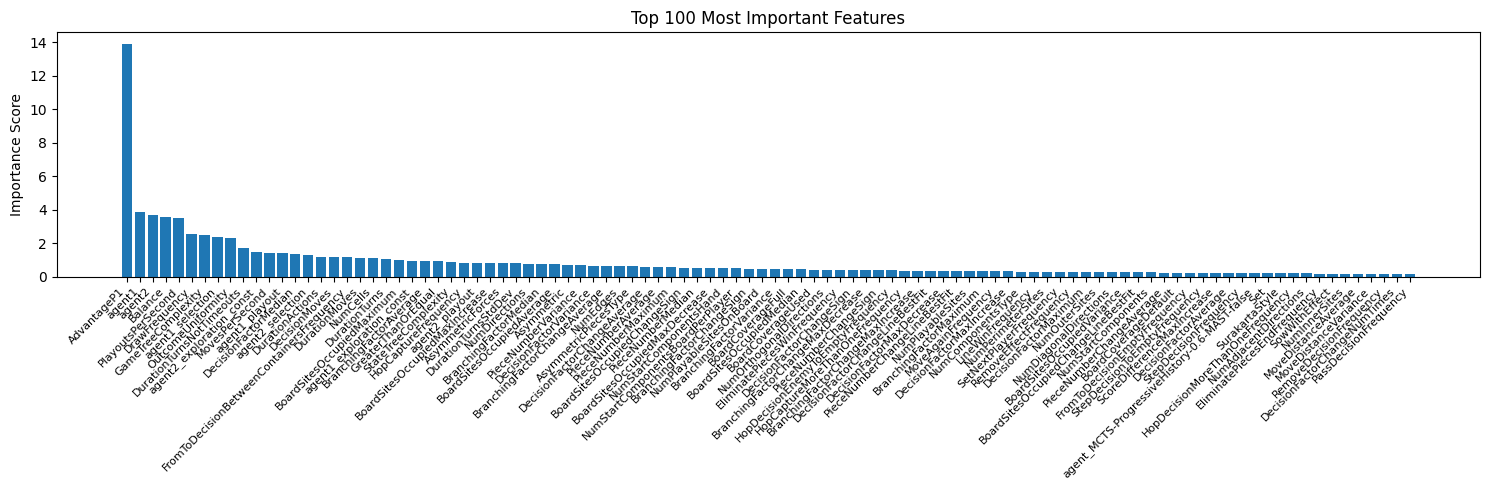

Fold 3 - RMSE: 0.4242009189920242
Fold 4


0:	learn: 0.6026895	test: 0.5907229	best: 0.5907229 (0)	total: 99.1ms	remaining: 4m 57s


50:	learn: 0.3859913	test: 0.4837068	best: 0.4837068 (50)	total: 5.29s	remaining: 5m 6s


100:	learn: 0.3485528	test: 0.4631698	best: 0.4631698 (100)	total: 10.8s	remaining: 5m 8s


150:	learn: 0.3245885	test: 0.4543224	best: 0.4543224 (150)	total: 16.1s	remaining: 5m 3s


200:	learn: 0.3068443	test: 0.4497983	best: 0.4497983 (200)	total: 21.4s	remaining: 4m 58s


250:	learn: 0.2948513	test: 0.4471787	best: 0.4471787 (250)	total: 26.8s	remaining: 4m 53s


300:	learn: 0.2848586	test: 0.4462894	best: 0.4462758 (298)	total: 32.2s	remaining: 4m 48s


350:	learn: 0.2768346	test: 0.4450887	best: 0.4450887 (350)	total: 37.6s	remaining: 4m 43s


400:	learn: 0.2697763	test: 0.4441179	best: 0.4440427 (399)	total: 43s	remaining: 4m 38s


450:	learn: 0.2638315	test: 0.4432994	best: 0.4432763 (449)	total: 48.4s	remaining: 4m 33s


500:	learn: 0.2581425	test: 0.4422909	best: 0.4422491 (498)	total: 53.8s	remaining: 4m 28s


550:	learn: 0.2536767	test: 0.4417710	best: 0.4417301 (549)	total: 59.3s	remaining: 4m 23s


600:	learn: 0.2488819	test: 0.4415448	best: 0.4414964 (598)	total: 1m 4s	remaining: 4m 18s


650:	learn: 0.2449611	test: 0.4412621	best: 0.4412621 (650)	total: 1m 10s	remaining: 4m 13s


700:	learn: 0.2410962	test: 0.4405661	best: 0.4405337 (697)	total: 1m 15s	remaining: 4m 8s


750:	learn: 0.2375418	test: 0.4401648	best: 0.4401640 (749)	total: 1m 21s	remaining: 4m 2s


800:	learn: 0.2343562	test: 0.4400418	best: 0.4399578 (799)	total: 1m 26s	remaining: 3m 57s


850:	learn: 0.2315460	test: 0.4399045	best: 0.4398828 (849)	total: 1m 32s	remaining: 3m 52s


900:	learn: 0.2289750	test: 0.4397223	best: 0.4397223 (900)	total: 1m 37s	remaining: 3m 47s


950:	learn: 0.2263889	test: 0.4396517	best: 0.4396310 (923)	total: 1m 43s	remaining: 3m 42s


1000:	learn: 0.2237935	test: 0.4395496	best: 0.4395483 (995)	total: 1m 48s	remaining: 3m 36s


1050:	learn: 0.2214361	test: 0.4395940	best: 0.4394934 (1010)	total: 1m 53s	remaining: 3m 31s


1100:	learn: 0.2191931	test: 0.4393961	best: 0.4393961 (1100)	total: 1m 59s	remaining: 3m 25s


1150:	learn: 0.2169646	test: 0.4393047	best: 0.4393047 (1150)	total: 2m 4s	remaining: 3m 20s


1200:	learn: 0.2150246	test: 0.4392508	best: 0.4392299 (1171)	total: 2m 10s	remaining: 3m 15s


1250:	learn: 0.2128917	test: 0.4393372	best: 0.4392299 (1171)	total: 2m 16s	remaining: 3m 10s


1300:	learn: 0.2108362	test: 0.4392105	best: 0.4391708 (1294)	total: 2m 22s	remaining: 3m 5s


1350:	learn: 0.2089319	test: 0.4392178	best: 0.4391568 (1324)	total: 2m 27s	remaining: 3m


1400:	learn: 0.2069338	test: 0.4391295	best: 0.4391295 (1400)	total: 2m 33s	remaining: 2m 54s


1450:	learn: 0.2051582	test: 0.4390386	best: 0.4390386 (1450)	total: 2m 38s	remaining: 2m 49s


1500:	learn: 0.2036286	test: 0.4389672	best: 0.4389556 (1495)	total: 2m 44s	remaining: 2m 44s


1550:	learn: 0.2017513	test: 0.4389314	best: 0.4389131 (1528)	total: 2m 49s	remaining: 2m 38s


1600:	learn: 0.2003347	test: 0.4388652	best: 0.4388542 (1586)	total: 2m 55s	remaining: 2m 33s


1650:	learn: 0.1987856	test: 0.4388525	best: 0.4388450 (1639)	total: 3m 1s	remaining: 2m 27s


1700:	learn: 0.1970301	test: 0.4389056	best: 0.4388450 (1639)	total: 3m 6s	remaining: 2m 22s


1750:	learn: 0.1954190	test: 0.4388083	best: 0.4388061 (1747)	total: 3m 12s	remaining: 2m 17s


1800:	learn: 0.1939899	test: 0.4387508	best: 0.4387358 (1798)	total: 3m 17s	remaining: 2m 11s


1850:	learn: 0.1924783	test: 0.4387324	best: 0.4387068 (1819)	total: 3m 23s	remaining: 2m 6s


1900:	learn: 0.1910645	test: 0.4386818	best: 0.4386818 (1900)	total: 3m 28s	remaining: 2m


1950:	learn: 0.1897122	test: 0.4386891	best: 0.4386748 (1904)	total: 3m 34s	remaining: 1m 55s


2000:	learn: 0.1883911	test: 0.4385964	best: 0.4385659 (1989)	total: 3m 39s	remaining: 1m 49s


2050:	learn: 0.1870652	test: 0.4383896	best: 0.4383869 (2041)	total: 3m 45s	remaining: 1m 44s


2100:	learn: 0.1857202	test: 0.4383999	best: 0.4383500 (2083)	total: 3m 51s	remaining: 1m 38s


2150:	learn: 0.1844790	test: 0.4383829	best: 0.4383500 (2083)	total: 3m 56s	remaining: 1m 33s


2200:	learn: 0.1831018	test: 0.4382936	best: 0.4382878 (2199)	total: 4m 2s	remaining: 1m 27s


2250:	learn: 0.1818131	test: 0.4382045	best: 0.4382043 (2249)	total: 4m 7s	remaining: 1m 22s


2300:	learn: 0.1806292	test: 0.4382229	best: 0.4381902 (2261)	total: 4m 13s	remaining: 1m 16s


2350:	learn: 0.1793428	test: 0.4381918	best: 0.4381529 (2338)	total: 4m 18s	remaining: 1m 11s


2400:	learn: 0.1780499	test: 0.4381680	best: 0.4381529 (2338)	total: 4m 24s	remaining: 1m 5s


2450:	learn: 0.1768820	test: 0.4381845	best: 0.4381529 (2338)	total: 4m 29s	remaining: 1m


2500:	learn: 0.1756042	test: 0.4381703	best: 0.4381441 (2476)	total: 4m 35s	remaining: 54.9s


2550:	learn: 0.1744579	test: 0.4381206	best: 0.4381178 (2531)	total: 4m 40s	remaining: 49.4s


2600:	learn: 0.1733607	test: 0.4381209	best: 0.4381178 (2531)	total: 4m 46s	remaining: 43.9s


2650:	learn: 0.1721612	test: 0.4380797	best: 0.4380728 (2648)	total: 4m 51s	remaining: 38.4s


2700:	learn: 0.1710367	test: 0.4380909	best: 0.4380728 (2648)	total: 4m 57s	remaining: 32.9s


2750:	learn: 0.1699157	test: 0.4380548	best: 0.4380404 (2745)	total: 5m 3s	remaining: 27.4s


2800:	learn: 0.1688496	test: 0.4380852	best: 0.4380404 (2745)	total: 5m 8s	remaining: 21.9s


2850:	learn: 0.1676410	test: 0.4380440	best: 0.4380381 (2849)	total: 5m 14s	remaining: 16.4s


2900:	learn: 0.1665314	test: 0.4380130	best: 0.4380130 (2900)	total: 5m 19s	remaining: 10.9s


2950:	learn: 0.1655084	test: 0.4380321	best: 0.4380103 (2909)	total: 5m 25s	remaining: 5.4s


2999:	learn: 0.1644209	test: 0.4379912	best: 0.4379828 (2984)	total: 5m 30s	remaining: 0us

bestTest = 0.4379828156
bestIteration = 2984

Shrink model to first 2985 iterations.


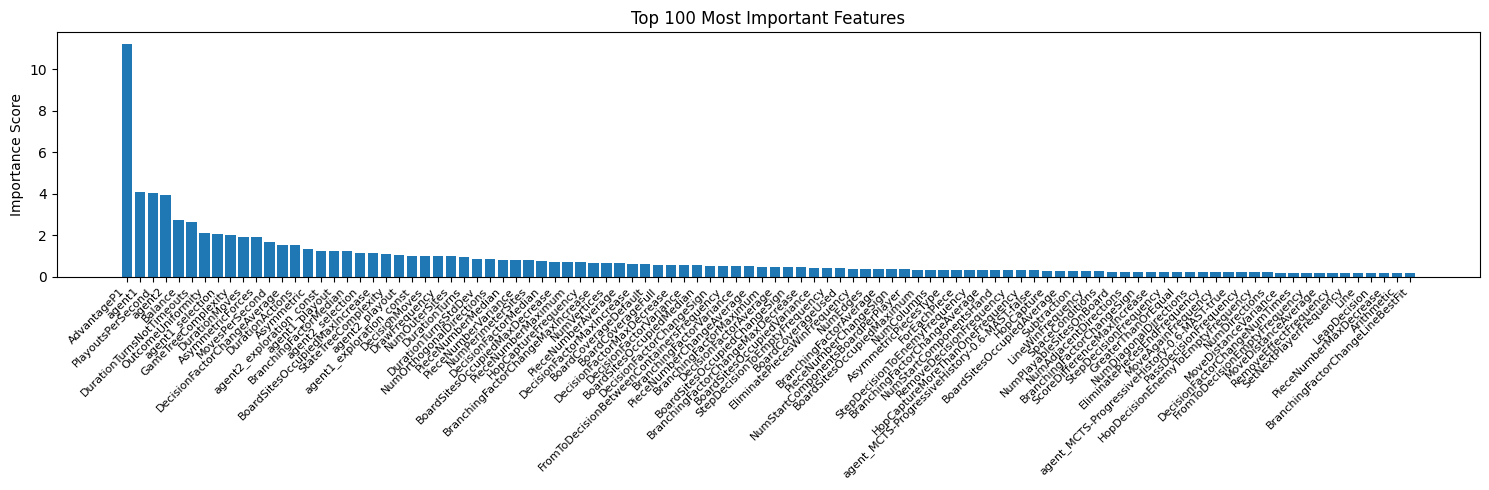

Fold 4 - RMSE: 0.4371436037174661
Fold 5


0:	learn: 0.6169336	test: 0.5440085	best: 0.5440085 (0)	total: 92.2ms	remaining: 4m 36s


50:	learn: 0.3976238	test: 0.4529462	best: 0.4529462 (50)	total: 5.28s	remaining: 5m 5s


100:	learn: 0.3566326	test: 0.4314544	best: 0.4314544 (100)	total: 10.9s	remaining: 5m 12s


150:	learn: 0.3329299	test: 0.4238172	best: 0.4238172 (150)	total: 16.3s	remaining: 5m 6s


200:	learn: 0.3163953	test: 0.4189652	best: 0.4189652 (200)	total: 21.7s	remaining: 5m 1s


250:	learn: 0.3037764	test: 0.4159472	best: 0.4159472 (250)	total: 27.1s	remaining: 4m 56s


300:	learn: 0.2939676	test: 0.4142789	best: 0.4142772 (297)	total: 32.7s	remaining: 4m 53s


350:	learn: 0.2854746	test: 0.4133109	best: 0.4132390 (345)	total: 38.3s	remaining: 4m 49s


400:	learn: 0.2778843	test: 0.4118317	best: 0.4116903 (397)	total: 44s	remaining: 4m 45s


450:	learn: 0.2715758	test: 0.4113114	best: 0.4112762 (449)	total: 50s	remaining: 4m 42s


500:	learn: 0.2659774	test: 0.4108620	best: 0.4108065 (490)	total: 55.5s	remaining: 4m 36s


550:	learn: 0.2606898	test: 0.4100482	best: 0.4100401 (549)	total: 1m 1s	remaining: 4m 31s


600:	learn: 0.2563245	test: 0.4094643	best: 0.4094515 (599)	total: 1m 6s	remaining: 4m 26s


650:	learn: 0.2519809	test: 0.4095597	best: 0.4094387 (606)	total: 1m 12s	remaining: 4m 20s


700:	learn: 0.2484698	test: 0.4092692	best: 0.4092677 (698)	total: 1m 17s	remaining: 4m 15s


750:	learn: 0.2448538	test: 0.4088343	best: 0.4087861 (734)	total: 1m 23s	remaining: 4m 9s


800:	learn: 0.2412888	test: 0.4085601	best: 0.4085601 (800)	total: 1m 28s	remaining: 4m 4s


850:	learn: 0.2380791	test: 0.4081388	best: 0.4081359 (843)	total: 1m 34s	remaining: 3m 58s


900:	learn: 0.2348469	test: 0.4078746	best: 0.4078708 (896)	total: 1m 40s	remaining: 3m 53s


950:	learn: 0.2317730	test: 0.4077324	best: 0.4077247 (949)	total: 1m 45s	remaining: 3m 47s


1000:	learn: 0.2289588	test: 0.4073709	best: 0.4073537 (990)	total: 1m 51s	remaining: 3m 41s


1050:	learn: 0.2262624	test: 0.4073069	best: 0.4073069 (1050)	total: 1m 56s	remaining: 3m 36s


1100:	learn: 0.2240202	test: 0.4072977	best: 0.4072420 (1056)	total: 2m 2s	remaining: 3m 30s


1150:	learn: 0.2218454	test: 0.4073068	best: 0.4072404 (1133)	total: 2m 7s	remaining: 3m 24s


1200:	learn: 0.2196142	test: 0.4072813	best: 0.4072185 (1180)	total: 2m 13s	remaining: 3m 19s


1250:	learn: 0.2175052	test: 0.4072192	best: 0.4072158 (1219)	total: 2m 18s	remaining: 3m 14s


1300:	learn: 0.2153406	test: 0.4071741	best: 0.4071464 (1252)	total: 2m 24s	remaining: 3m 9s


1350:	learn: 0.2131153	test: 0.4071472	best: 0.4071316 (1322)	total: 2m 30s	remaining: 3m 3s


1400:	learn: 0.2109272	test: 0.4070774	best: 0.4070760 (1396)	total: 2m 35s	remaining: 2m 57s


1450:	learn: 0.2089052	test: 0.4068497	best: 0.4068497 (1450)	total: 2m 41s	remaining: 2m 52s


1500:	learn: 0.2069223	test: 0.4068191	best: 0.4067855 (1492)	total: 2m 46s	remaining: 2m 46s


1550:	learn: 0.2051822	test: 0.4068370	best: 0.4067855 (1492)	total: 2m 52s	remaining: 2m 41s


1600:	learn: 0.2033743	test: 0.4068503	best: 0.4067855 (1492)	total: 2m 57s	remaining: 2m 35s


1650:	learn: 0.2016391	test: 0.4068639	best: 0.4067855 (1492)	total: 3m 3s	remaining: 2m 29s


1700:	learn: 0.1998047	test: 0.4068541	best: 0.4067855 (1492)	total: 3m 8s	remaining: 2m 24s


1750:	learn: 0.1980124	test: 0.4067821	best: 0.4067600 (1721)	total: 3m 14s	remaining: 2m 18s


1800:	learn: 0.1964685	test: 0.4067331	best: 0.4066953 (1795)	total: 3m 19s	remaining: 2m 13s


1850:	learn: 0.1949329	test: 0.4066742	best: 0.4066671 (1849)	total: 3m 25s	remaining: 2m 7s


1900:	learn: 0.1934583	test: 0.4066610	best: 0.4066511 (1880)	total: 3m 30s	remaining: 2m 1s


1950:	learn: 0.1919091	test: 0.4066164	best: 0.4066108 (1946)	total: 3m 36s	remaining: 1m 56s


2000:	learn: 0.1903472	test: 0.4065726	best: 0.4065698 (1975)	total: 3m 41s	remaining: 1m 50s


2050:	learn: 0.1889708	test: 0.4066286	best: 0.4065698 (1975)	total: 3m 47s	remaining: 1m 45s


2100:	learn: 0.1874319	test: 0.4066122	best: 0.4065698 (1975)	total: 3m 53s	remaining: 1m 39s


2150:	learn: 0.1859377	test: 0.4065460	best: 0.4065077 (2139)	total: 3m 58s	remaining: 1m 34s


2200:	learn: 0.1845284	test: 0.4064904	best: 0.4064850 (2195)	total: 4m 4s	remaining: 1m 28s


2250:	learn: 0.1831286	test: 0.4064897	best: 0.4064316 (2236)	total: 4m 9s	remaining: 1m 23s


2300:	learn: 0.1817758	test: 0.4064388	best: 0.4064273 (2294)	total: 4m 15s	remaining: 1m 17s


2350:	learn: 0.1805257	test: 0.4064509	best: 0.4064273 (2294)	total: 4m 20s	remaining: 1m 11s


2400:	learn: 0.1792064	test: 0.4065354	best: 0.4064273 (2294)	total: 4m 26s	remaining: 1m 6s


2450:	learn: 0.1779081	test: 0.4065833	best: 0.4064273 (2294)	total: 4m 32s	remaining: 1m


2500:	learn: 0.1767379	test: 0.4065309	best: 0.4064273 (2294)	total: 4m 37s	remaining: 55.4s


2550:	learn: 0.1755339	test: 0.4065250	best: 0.4064273 (2294)	total: 4m 43s	remaining: 49.8s


2600:	learn: 0.1744074	test: 0.4065086	best: 0.4064273 (2294)	total: 4m 48s	remaining: 44.3s


2650:	learn: 0.1732729	test: 0.4065456	best: 0.4064273 (2294)	total: 4m 54s	remaining: 38.7s


2700:	learn: 0.1721326	test: 0.4066216	best: 0.4064273 (2294)	total: 4m 59s	remaining: 33.2s


2750:	learn: 0.1709736	test: 0.4066044	best: 0.4064273 (2294)	total: 5m 5s	remaining: 27.6s


2800:	learn: 0.1698517	test: 0.4065882	best: 0.4064273 (2294)	total: 5m 10s	remaining: 22.1s


2850:	learn: 0.1686826	test: 0.4065550	best: 0.4064273 (2294)	total: 5m 16s	remaining: 16.5s


2900:	learn: 0.1676567	test: 0.4065820	best: 0.4064273 (2294)	total: 5m 21s	remaining: 11s


2950:	learn: 0.1665852	test: 0.4066017	best: 0.4064273 (2294)	total: 5m 26s	remaining: 5.43s


2999:	learn: 0.1656344	test: 0.4066114	best: 0.4064273 (2294)	total: 5m 32s	remaining: 0us

bestTest = 0.406427309
bestIteration = 2294

Shrink model to first 2295 iterations.


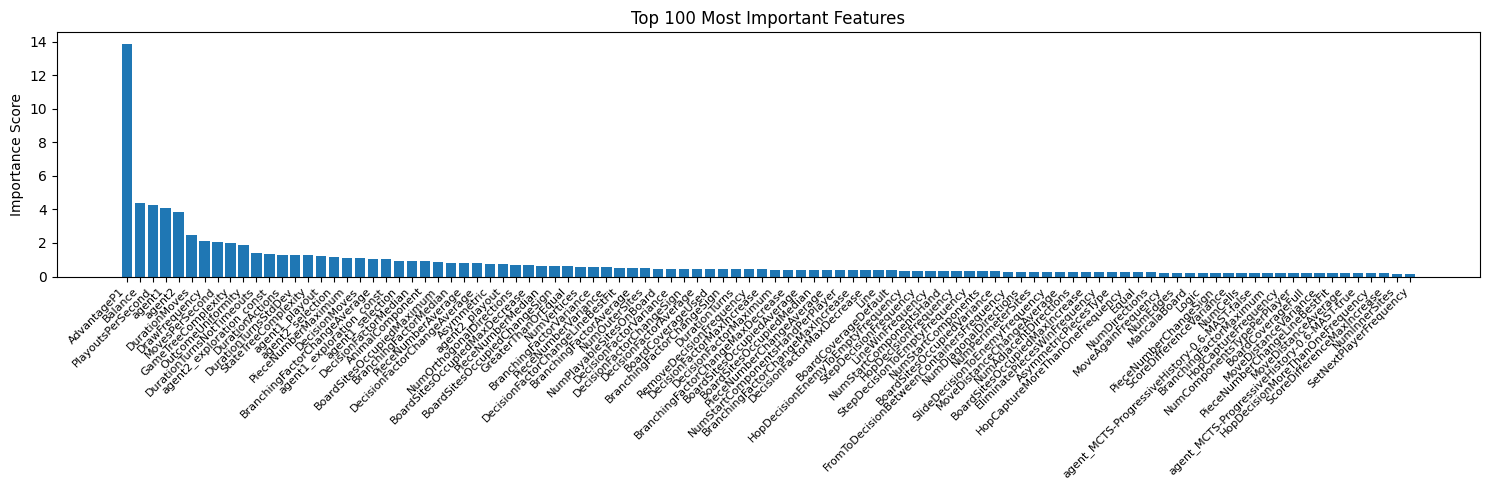

Fold 5 - RMSE: 0.40592033250209286
List of oof scores: [0.41556281529000255, 0.4426060145876793, 0.4242009189920242, 0.4371436037174661, 0.40592033250209286]
Average oof score: 0.425086737017853


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6159298	test: 0.5300701	best: 0.5300701 (0)	total: 91.2ms	remaining: 4m 33s


50:	learn: 0.3932838	test: 0.4469471	best: 0.4469471 (50)	total: 5.39s	remaining: 5m 11s


100:	learn: 0.3548326	test: 0.4355747	best: 0.4355747 (100)	total: 11.3s	remaining: 5m 23s


150:	learn: 0.3300734	test: 0.4297480	best: 0.4297480 (150)	total: 17s	remaining: 5m 20s


200:	learn: 0.3139313	test: 0.4256718	best: 0.4256718 (200)	total: 22.4s	remaining: 5m 11s


250:	learn: 0.3014753	test: 0.4231561	best: 0.4231561 (250)	total: 27.9s	remaining: 5m 5s


300:	learn: 0.2921982	test: 0.4213982	best: 0.4213982 (300)	total: 33.5s	remaining: 5m


350:	learn: 0.2837153	test: 0.4197190	best: 0.4197120 (349)	total: 39.1s	remaining: 4m 55s


400:	learn: 0.2761535	test: 0.4186868	best: 0.4186868 (400)	total: 44.6s	remaining: 4m 49s


450:	learn: 0.2692076	test: 0.4180250	best: 0.4179732 (448)	total: 50s	remaining: 4m 42s


500:	learn: 0.2631353	test: 0.4173476	best: 0.4173156 (496)	total: 55.4s	remaining: 4m 36s


550:	learn: 0.2578424	test: 0.4167242	best: 0.4167001 (549)	total: 1m	remaining: 4m 30s


600:	learn: 0.2531578	test: 0.4159257	best: 0.4159257 (600)	total: 1m 6s	remaining: 4m 24s


650:	learn: 0.2491270	test: 0.4154312	best: 0.4154312 (650)	total: 1m 11s	remaining: 4m 19s


700:	learn: 0.2451208	test: 0.4151182	best: 0.4150816 (690)	total: 1m 17s	remaining: 4m 13s


750:	learn: 0.2410532	test: 0.4147463	best: 0.4147413 (749)	total: 1m 22s	remaining: 4m 7s


800:	learn: 0.2376441	test: 0.4143223	best: 0.4142694 (797)	total: 1m 28s	remaining: 4m 1s


850:	learn: 0.2341679	test: 0.4141549	best: 0.4141341 (849)	total: 1m 33s	remaining: 3m 55s


900:	learn: 0.2312883	test: 0.4140098	best: 0.4140098 (900)	total: 1m 39s	remaining: 3m 50s


950:	learn: 0.2286893	test: 0.4138680	best: 0.4138680 (950)	total: 1m 45s	remaining: 3m 46s


1000:	learn: 0.2257960	test: 0.4135818	best: 0.4135543 (993)	total: 1m 50s	remaining: 3m 40s


1050:	learn: 0.2230887	test: 0.4135713	best: 0.4135418 (1002)	total: 1m 55s	remaining: 3m 35s


1100:	learn: 0.2206656	test: 0.4132401	best: 0.4132401 (1100)	total: 2m 1s	remaining: 3m 29s


1150:	learn: 0.2184513	test: 0.4132290	best: 0.4132290 (1149)	total: 2m 6s	remaining: 3m 23s


1200:	learn: 0.2160572	test: 0.4130670	best: 0.4130393 (1198)	total: 2m 12s	remaining: 3m 18s


1250:	learn: 0.2137306	test: 0.4127617	best: 0.4126980 (1237)	total: 2m 17s	remaining: 3m 12s


1300:	learn: 0.2118031	test: 0.4127294	best: 0.4126980 (1237)	total: 2m 23s	remaining: 3m 7s


1350:	learn: 0.2097144	test: 0.4125694	best: 0.4125336 (1335)	total: 2m 29s	remaining: 3m 2s


1400:	learn: 0.2077334	test: 0.4124895	best: 0.4124849 (1396)	total: 2m 34s	remaining: 2m 56s


1450:	learn: 0.2056391	test: 0.4124398	best: 0.4123735 (1432)	total: 2m 40s	remaining: 2m 51s


1500:	learn: 0.2037490	test: 0.4124688	best: 0.4123735 (1432)	total: 2m 45s	remaining: 2m 45s


1550:	learn: 0.2018990	test: 0.4123223	best: 0.4123223 (1550)	total: 2m 51s	remaining: 2m 40s


1600:	learn: 0.2000758	test: 0.4121878	best: 0.4121878 (1600)	total: 2m 57s	remaining: 2m 34s


1650:	learn: 0.1983461	test: 0.4120712	best: 0.4120666 (1640)	total: 3m 2s	remaining: 2m 29s


1700:	learn: 0.1967454	test: 0.4120769	best: 0.4120666 (1640)	total: 3m 8s	remaining: 2m 23s


1750:	learn: 0.1949790	test: 0.4119839	best: 0.4119729 (1744)	total: 3m 14s	remaining: 2m 18s


1800:	learn: 0.1933991	test: 0.4118378	best: 0.4118278 (1799)	total: 3m 19s	remaining: 2m 13s


1850:	learn: 0.1918589	test: 0.4118015	best: 0.4117793 (1831)	total: 3m 25s	remaining: 2m 7s


1900:	learn: 0.1903775	test: 0.4117977	best: 0.4117793 (1831)	total: 3m 31s	remaining: 2m 2s


1950:	learn: 0.1888772	test: 0.4117476	best: 0.4117358 (1948)	total: 3m 37s	remaining: 1m 56s


2000:	learn: 0.1873043	test: 0.4117799	best: 0.4117358 (1948)	total: 3m 42s	remaining: 1m 51s


2050:	learn: 0.1859638	test: 0.4118705	best: 0.4117358 (1948)	total: 3m 48s	remaining: 1m 45s


2100:	learn: 0.1846290	test: 0.4117994	best: 0.4117358 (1948)	total: 3m 53s	remaining: 1m 39s


2150:	learn: 0.1832269	test: 0.4118143	best: 0.4117358 (1948)	total: 3m 59s	remaining: 1m 34s


2200:	learn: 0.1817343	test: 0.4117529	best: 0.4117358 (1948)	total: 4m 4s	remaining: 1m 28s


2250:	learn: 0.1804102	test: 0.4116987	best: 0.4116987 (2250)	total: 4m 9s	remaining: 1m 23s


2300:	learn: 0.1790715	test: 0.4117001	best: 0.4116727 (2267)	total: 4m 15s	remaining: 1m 17s


2350:	learn: 0.1779057	test: 0.4116710	best: 0.4116665 (2347)	total: 4m 20s	remaining: 1m 12s


2400:	learn: 0.1766759	test: 0.4116742	best: 0.4116637 (2367)	total: 4m 26s	remaining: 1m 6s


2450:	learn: 0.1753646	test: 0.4116674	best: 0.4116637 (2367)	total: 4m 31s	remaining: 1m


2500:	learn: 0.1740526	test: 0.4116618	best: 0.4116253 (2477)	total: 4m 37s	remaining: 55.3s


2550:	learn: 0.1728301	test: 0.4116721	best: 0.4116253 (2477)	total: 4m 42s	remaining: 49.8s


2600:	learn: 0.1717553	test: 0.4116272	best: 0.4116160 (2587)	total: 4m 48s	remaining: 44.2s


2650:	learn: 0.1705921	test: 0.4115908	best: 0.4115818 (2647)	total: 4m 53s	remaining: 38.7s


2700:	learn: 0.1695305	test: 0.4116149	best: 0.4115818 (2647)	total: 4m 59s	remaining: 33.1s


2750:	learn: 0.1683355	test: 0.4115794	best: 0.4115739 (2746)	total: 5m 4s	remaining: 27.6s


2800:	learn: 0.1672185	test: 0.4116470	best: 0.4115739 (2746)	total: 5m 10s	remaining: 22.1s


2850:	learn: 0.1661531	test: 0.4116430	best: 0.4115739 (2746)	total: 5m 15s	remaining: 16.5s


2900:	learn: 0.1652165	test: 0.4116489	best: 0.4115739 (2746)	total: 5m 21s	remaining: 11s


2950:	learn: 0.1640777	test: 0.4116421	best: 0.4115739 (2746)	total: 5m 27s	remaining: 5.43s


2999:	learn: 0.1629288	test: 0.4116721	best: 0.4115739 (2746)	total: 5m 32s	remaining: 0us

bestTest = 0.4115739316
bestIteration = 2746

Shrink model to first 2747 iterations.


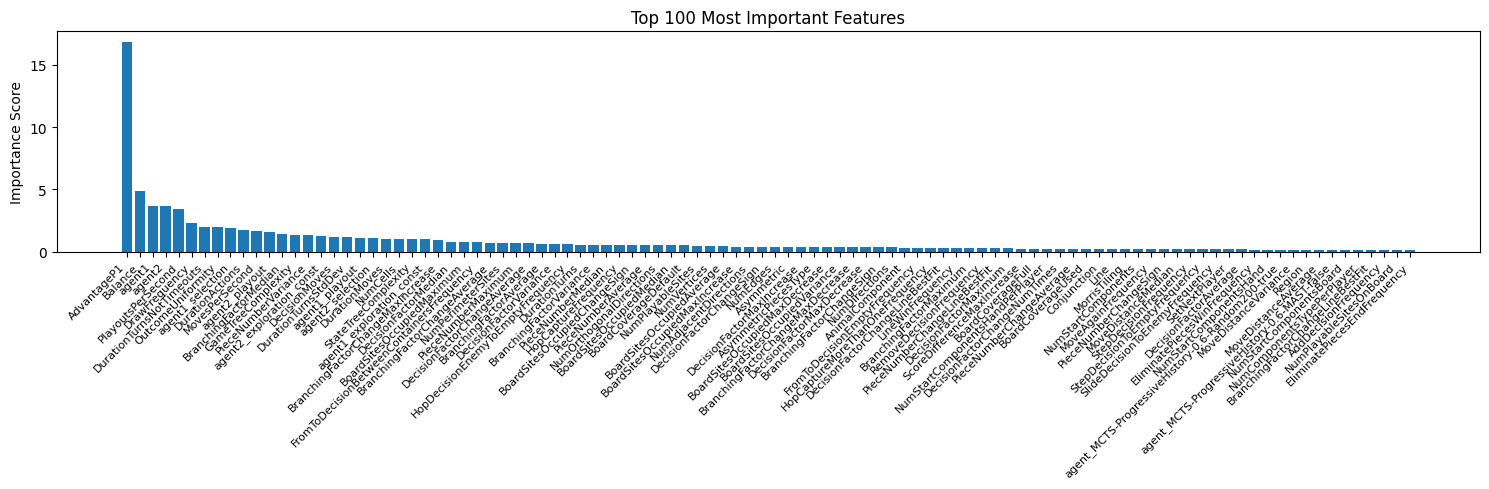

Fold 1 - RMSE: 0.4112667694646939
Fold 2


0:	learn: 0.6137686	test: 0.5386543	best: 0.5386543 (0)	total: 103ms	remaining: 5m 8s


50:	learn: 0.3907119	test: 0.4267617	best: 0.4267617 (50)	total: 5.46s	remaining: 5m 15s


100:	learn: 0.3512417	test: 0.4125143	best: 0.4125143 (100)	total: 11s	remaining: 5m 15s


150:	learn: 0.3272190	test: 0.4074853	best: 0.4074731 (147)	total: 16.4s	remaining: 5m 10s


200:	learn: 0.3104077	test: 0.4050095	best: 0.4049270 (199)	total: 22.1s	remaining: 5m 7s


250:	learn: 0.2979034	test: 0.4037979	best: 0.4036838 (245)	total: 27.6s	remaining: 5m 2s


300:	learn: 0.2881669	test: 0.4029459	best: 0.4028925 (294)	total: 33.1s	remaining: 4m 56s


350:	learn: 0.2794753	test: 0.4017347	best: 0.4017347 (350)	total: 38.5s	remaining: 4m 50s


400:	learn: 0.2724522	test: 0.4009858	best: 0.4009858 (400)	total: 44s	remaining: 4m 45s


450:	learn: 0.2655342	test: 0.4008542	best: 0.4006890 (442)	total: 49.4s	remaining: 4m 39s


500:	learn: 0.2595814	test: 0.4003378	best: 0.4003378 (500)	total: 55s	remaining: 4m 34s


550:	learn: 0.2544403	test: 0.4004696	best: 0.4002047 (510)	total: 1m	remaining: 4m 28s


600:	learn: 0.2497777	test: 0.4005591	best: 0.4002047 (510)	total: 1m 5s	remaining: 4m 23s


650:	learn: 0.2457689	test: 0.4005111	best: 0.4002047 (510)	total: 1m 11s	remaining: 4m 18s


700:	learn: 0.2419846	test: 0.4005509	best: 0.4002047 (510)	total: 1m 17s	remaining: 4m 12s


750:	learn: 0.2384939	test: 0.4003082	best: 0.4002047 (510)	total: 1m 22s	remaining: 4m 7s


800:	learn: 0.2352559	test: 0.4001941	best: 0.4001941 (800)	total: 1m 28s	remaining: 4m 2s


850:	learn: 0.2324011	test: 0.4003978	best: 0.4001883 (802)	total: 1m 33s	remaining: 3m 57s


900:	learn: 0.2292663	test: 0.4000774	best: 0.4000774 (900)	total: 1m 39s	remaining: 3m 51s


950:	learn: 0.2261410	test: 0.4003402	best: 0.4000620 (901)	total: 1m 45s	remaining: 3m 46s


1000:	learn: 0.2235311	test: 0.4004090	best: 0.4000620 (901)	total: 1m 50s	remaining: 3m 40s


1050:	learn: 0.2212696	test: 0.4002384	best: 0.4000620 (901)	total: 1m 56s	remaining: 3m 35s


1100:	learn: 0.2187695	test: 0.4003917	best: 0.4000620 (901)	total: 2m 1s	remaining: 3m 29s


1150:	learn: 0.2165005	test: 0.4005218	best: 0.4000620 (901)	total: 2m 7s	remaining: 3m 24s


1200:	learn: 0.2143302	test: 0.4004254	best: 0.4000620 (901)	total: 2m 12s	remaining: 3m 18s


1250:	learn: 0.2123937	test: 0.4004234	best: 0.4000620 (901)	total: 2m 18s	remaining: 3m 13s


1300:	learn: 0.2103145	test: 0.4003078	best: 0.4000620 (901)	total: 2m 23s	remaining: 3m 7s


1350:	learn: 0.2082892	test: 0.4002380	best: 0.4000620 (901)	total: 2m 29s	remaining: 3m 2s


1400:	learn: 0.2062575	test: 0.4003390	best: 0.4000620 (901)	total: 2m 34s	remaining: 2m 56s


1450:	learn: 0.2043543	test: 0.4004162	best: 0.4000620 (901)	total: 2m 40s	remaining: 2m 51s


1500:	learn: 0.2025111	test: 0.4003944	best: 0.4000620 (901)	total: 2m 45s	remaining: 2m 45s


1550:	learn: 0.2006341	test: 0.4003978	best: 0.4000620 (901)	total: 2m 51s	remaining: 2m 40s


1600:	learn: 0.1989967	test: 0.4003673	best: 0.4000620 (901)	total: 2m 56s	remaining: 2m 34s


1650:	learn: 0.1973006	test: 0.4003333	best: 0.4000620 (901)	total: 3m 2s	remaining: 2m 29s


1700:	learn: 0.1957119	test: 0.4004064	best: 0.4000620 (901)	total: 3m 8s	remaining: 2m 23s


1750:	learn: 0.1939907	test: 0.4004249	best: 0.4000620 (901)	total: 3m 13s	remaining: 2m 18s


1800:	learn: 0.1923576	test: 0.4004562	best: 0.4000620 (901)	total: 3m 18s	remaining: 2m 12s


1850:	learn: 0.1908782	test: 0.4005440	best: 0.4000620 (901)	total: 3m 24s	remaining: 2m 7s


1900:	learn: 0.1893998	test: 0.4005525	best: 0.4000620 (901)	total: 3m 30s	remaining: 2m 1s


1950:	learn: 0.1879606	test: 0.4005872	best: 0.4000620 (901)	total: 3m 35s	remaining: 1m 56s


2000:	learn: 0.1864790	test: 0.4004454	best: 0.4000620 (901)	total: 3m 41s	remaining: 1m 50s


2050:	learn: 0.1850642	test: 0.4004638	best: 0.4000620 (901)	total: 3m 46s	remaining: 1m 44s


2100:	learn: 0.1837574	test: 0.4004787	best: 0.4000620 (901)	total: 3m 52s	remaining: 1m 39s


2150:	learn: 0.1825111	test: 0.4005666	best: 0.4000620 (901)	total: 3m 57s	remaining: 1m 33s


2200:	learn: 0.1812063	test: 0.4005437	best: 0.4000620 (901)	total: 4m 3s	remaining: 1m 28s


2250:	learn: 0.1799530	test: 0.4005982	best: 0.4000620 (901)	total: 4m 8s	remaining: 1m 22s


2300:	learn: 0.1786711	test: 0.4006296	best: 0.4000620 (901)	total: 4m 14s	remaining: 1m 17s


2350:	learn: 0.1774202	test: 0.4006818	best: 0.4000620 (901)	total: 4m 20s	remaining: 1m 11s


2400:	learn: 0.1761637	test: 0.4007193	best: 0.4000620 (901)	total: 4m 25s	remaining: 1m 6s


2450:	learn: 0.1748253	test: 0.4007078	best: 0.4000620 (901)	total: 4m 31s	remaining: 1m


2500:	learn: 0.1736154	test: 0.4007188	best: 0.4000620 (901)	total: 4m 37s	remaining: 55.3s


2550:	learn: 0.1724143	test: 0.4006880	best: 0.4000620 (901)	total: 4m 42s	remaining: 49.8s


2600:	learn: 0.1711968	test: 0.4007381	best: 0.4000620 (901)	total: 4m 48s	remaining: 44.2s


2650:	learn: 0.1700258	test: 0.4007220	best: 0.4000620 (901)	total: 4m 53s	remaining: 38.7s


2700:	learn: 0.1689167	test: 0.4007145	best: 0.4000620 (901)	total: 4m 59s	remaining: 33.1s


2750:	learn: 0.1677967	test: 0.4007383	best: 0.4000620 (901)	total: 5m 5s	remaining: 27.6s


2800:	learn: 0.1666932	test: 0.4007891	best: 0.4000620 (901)	total: 5m 10s	remaining: 22.1s


2850:	learn: 0.1656533	test: 0.4008123	best: 0.4000620 (901)	total: 5m 16s	remaining: 16.5s


2900:	learn: 0.1644723	test: 0.4008394	best: 0.4000620 (901)	total: 5m 22s	remaining: 11s


2950:	learn: 0.1633283	test: 0.4009159	best: 0.4000620 (901)	total: 5m 27s	remaining: 5.44s


2999:	learn: 0.1623140	test: 0.4009840	best: 0.4000620 (901)	total: 5m 33s	remaining: 0us

bestTest = 0.4000619919
bestIteration = 901

Shrink model to first 902 iterations.


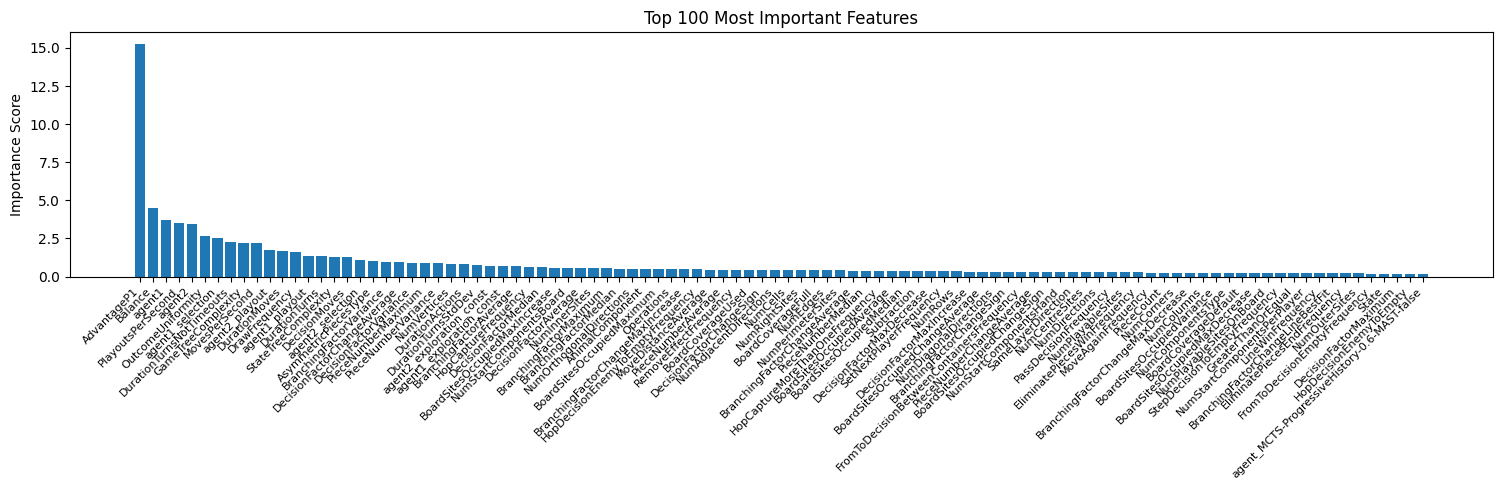

Fold 2 - RMSE: 0.39951157754984146
Fold 3


0:	learn: 0.6021816	test: 0.6067301	best: 0.6067301 (0)	total: 97.4ms	remaining: 4m 51s


50:	learn: 0.3821013	test: 0.4779238	best: 0.4779238 (50)	total: 5.43s	remaining: 5m 14s


100:	learn: 0.3446271	test: 0.4576710	best: 0.4576710 (100)	total: 11s	remaining: 5m 16s


150:	learn: 0.3222884	test: 0.4489840	best: 0.4489840 (150)	total: 16.5s	remaining: 5m 11s


200:	learn: 0.3061824	test: 0.4433267	best: 0.4433211 (199)	total: 21.9s	remaining: 5m 5s


250:	learn: 0.2936739	test: 0.4398792	best: 0.4398792 (250)	total: 27.3s	remaining: 4m 59s


300:	learn: 0.2846456	test: 0.4377456	best: 0.4376989 (299)	total: 32.8s	remaining: 4m 54s


350:	learn: 0.2765968	test: 0.4354195	best: 0.4354195 (350)	total: 38.3s	remaining: 4m 49s


400:	learn: 0.2697116	test: 0.4341893	best: 0.4341893 (400)	total: 43.9s	remaining: 4m 44s


450:	learn: 0.2639579	test: 0.4330316	best: 0.4330050 (449)	total: 49.4s	remaining: 4m 39s


500:	learn: 0.2586095	test: 0.4325486	best: 0.4325486 (500)	total: 55s	remaining: 4m 34s


550:	learn: 0.2539231	test: 0.4318448	best: 0.4317909 (549)	total: 1m	remaining: 4m 29s


600:	learn: 0.2496202	test: 0.4312682	best: 0.4312568 (599)	total: 1m 6s	remaining: 4m 25s


650:	learn: 0.2457160	test: 0.4305210	best: 0.4305210 (650)	total: 1m 12s	remaining: 4m 20s


700:	learn: 0.2419753	test: 0.4301060	best: 0.4300875 (698)	total: 1m 17s	remaining: 4m 15s


750:	learn: 0.2385555	test: 0.4295778	best: 0.4295778 (750)	total: 1m 23s	remaining: 4m 9s


800:	learn: 0.2353202	test: 0.4292209	best: 0.4292182 (795)	total: 1m 28s	remaining: 4m 4s


850:	learn: 0.2322942	test: 0.4290005	best: 0.4290005 (850)	total: 1m 34s	remaining: 3m 58s


900:	learn: 0.2292493	test: 0.4288811	best: 0.4288686 (898)	total: 1m 40s	remaining: 3m 53s


950:	learn: 0.2265008	test: 0.4288146	best: 0.4287980 (944)	total: 1m 45s	remaining: 3m 47s


1000:	learn: 0.2240173	test: 0.4283563	best: 0.4283563 (1000)	total: 1m 51s	remaining: 3m 42s


1050:	learn: 0.2216308	test: 0.4281172	best: 0.4281172 (1050)	total: 1m 56s	remaining: 3m 36s


1100:	learn: 0.2191183	test: 0.4278970	best: 0.4278911 (1091)	total: 2m 2s	remaining: 3m 31s


1150:	learn: 0.2169512	test: 0.4278480	best: 0.4277871 (1107)	total: 2m 8s	remaining: 3m 25s


1200:	learn: 0.2147532	test: 0.4276235	best: 0.4276035 (1197)	total: 2m 13s	remaining: 3m 20s


1250:	learn: 0.2126301	test: 0.4273513	best: 0.4273513 (1250)	total: 2m 19s	remaining: 3m 15s


1300:	learn: 0.2106230	test: 0.4272832	best: 0.4272802 (1291)	total: 2m 25s	remaining: 3m 9s


1350:	learn: 0.2085762	test: 0.4270884	best: 0.4270763 (1348)	total: 2m 30s	remaining: 3m 4s


1400:	learn: 0.2066721	test: 0.4270269	best: 0.4270133 (1365)	total: 2m 36s	remaining: 2m 58s


1450:	learn: 0.2048253	test: 0.4268296	best: 0.4267880 (1435)	total: 2m 41s	remaining: 2m 52s


1500:	learn: 0.2030758	test: 0.4266131	best: 0.4265987 (1493)	total: 2m 47s	remaining: 2m 47s


1550:	learn: 0.2014081	test: 0.4267293	best: 0.4265987 (1493)	total: 2m 53s	remaining: 2m 42s


1600:	learn: 0.1997095	test: 0.4265112	best: 0.4265112 (1600)	total: 2m 59s	remaining: 2m 36s


1650:	learn: 0.1980747	test: 0.4264113	best: 0.4264093 (1649)	total: 3m 4s	remaining: 2m 30s


1700:	learn: 0.1964838	test: 0.4262868	best: 0.4262763 (1690)	total: 3m 10s	remaining: 2m 25s


1750:	learn: 0.1949727	test: 0.4262827	best: 0.4262735 (1748)	total: 3m 16s	remaining: 2m 19s


1800:	learn: 0.1935019	test: 0.4263308	best: 0.4262635 (1754)	total: 3m 21s	remaining: 2m 14s


1850:	learn: 0.1919730	test: 0.4262730	best: 0.4262499 (1841)	total: 3m 27s	remaining: 2m 8s


1900:	learn: 0.1905931	test: 0.4262211	best: 0.4262153 (1896)	total: 3m 33s	remaining: 2m 3s


1950:	learn: 0.1892677	test: 0.4260717	best: 0.4260702 (1949)	total: 3m 38s	remaining: 1m 57s


2000:	learn: 0.1878512	test: 0.4260201	best: 0.4260201 (2000)	total: 3m 44s	remaining: 1m 52s


2050:	learn: 0.1865334	test: 0.4259563	best: 0.4259370 (2039)	total: 3m 50s	remaining: 1m 46s


2100:	learn: 0.1850934	test: 0.4258411	best: 0.4258238 (2092)	total: 3m 55s	remaining: 1m 40s


2150:	learn: 0.1836914	test: 0.4257617	best: 0.4257617 (2150)	total: 4m 1s	remaining: 1m 35s


2200:	learn: 0.1824933	test: 0.4256934	best: 0.4256901 (2197)	total: 4m 7s	remaining: 1m 29s


2250:	learn: 0.1810671	test: 0.4256341	best: 0.4256289 (2244)	total: 4m 12s	remaining: 1m 24s


2300:	learn: 0.1798520	test: 0.4255704	best: 0.4255681 (2297)	total: 4m 18s	remaining: 1m 18s


2350:	learn: 0.1786464	test: 0.4255140	best: 0.4255026 (2347)	total: 4m 24s	remaining: 1m 13s


2400:	learn: 0.1774137	test: 0.4254254	best: 0.4254073 (2394)	total: 4m 30s	remaining: 1m 7s


2450:	learn: 0.1762082	test: 0.4254442	best: 0.4254073 (2394)	total: 4m 36s	remaining: 1m 1s


2500:	learn: 0.1750806	test: 0.4254079	best: 0.4254032 (2497)	total: 4m 41s	remaining: 56.3s


2550:	learn: 0.1738866	test: 0.4253545	best: 0.4253545 (2550)	total: 4m 47s	remaining: 50.7s


2600:	learn: 0.1726304	test: 0.4253332	best: 0.4253210 (2590)	total: 4m 53s	remaining: 45s


2650:	learn: 0.1714222	test: 0.4252629	best: 0.4252542 (2635)	total: 4m 59s	remaining: 39.4s


2700:	learn: 0.1702131	test: 0.4252022	best: 0.4252022 (2700)	total: 5m 4s	remaining: 33.7s


2750:	learn: 0.1691392	test: 0.4252431	best: 0.4251922 (2705)	total: 5m 10s	remaining: 28.1s


2800:	learn: 0.1679623	test: 0.4252732	best: 0.4251922 (2705)	total: 5m 17s	remaining: 22.5s


2850:	learn: 0.1670003	test: 0.4252465	best: 0.4251922 (2705)	total: 5m 23s	remaining: 16.9s


2900:	learn: 0.1658884	test: 0.4252450	best: 0.4251922 (2705)	total: 5m 29s	remaining: 11.2s


2950:	learn: 0.1646875	test: 0.4252096	best: 0.4251922 (2705)	total: 5m 35s	remaining: 5.56s


2999:	learn: 0.1637525	test: 0.4251546	best: 0.4251525 (2997)	total: 5m 40s	remaining: 0us

bestTest = 0.4251524962
bestIteration = 2997

Shrink model to first 2998 iterations.


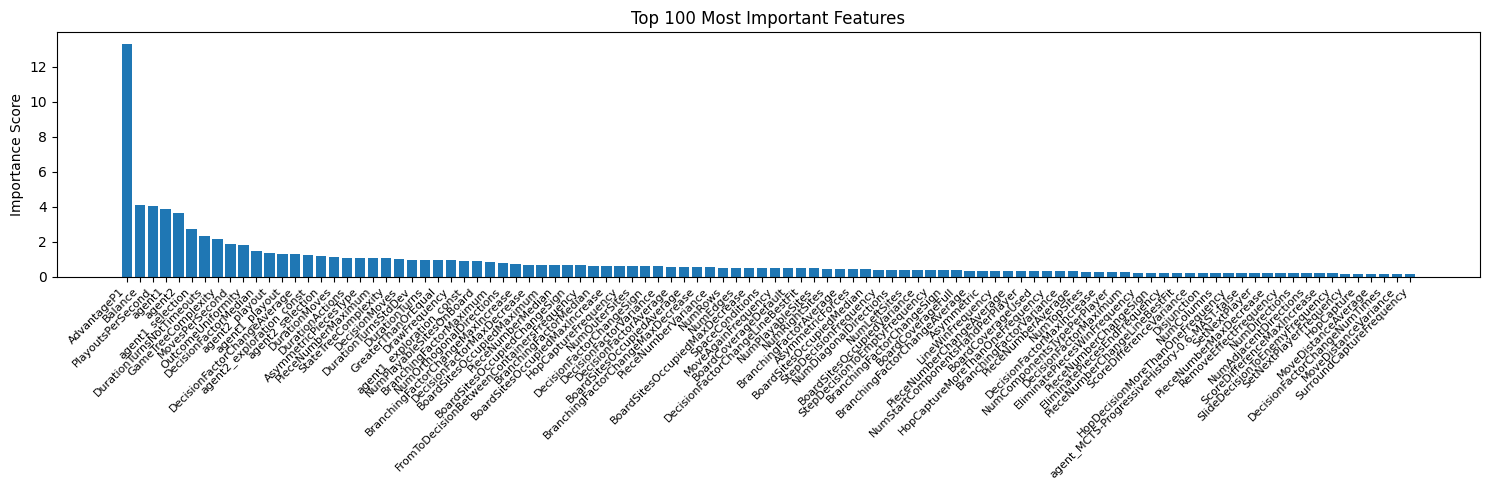

Fold 3 - RMSE: 0.42442527828021775
Fold 4


0:	learn: 0.6020666	test: 0.5964466	best: 0.5964466 (0)	total: 103ms	remaining: 5m 7s


50:	learn: 0.3882699	test: 0.4867790	best: 0.4867790 (50)	total: 5.71s	remaining: 5m 30s


100:	learn: 0.3495429	test: 0.4657334	best: 0.4657334 (100)	total: 11.4s	remaining: 5m 26s


150:	learn: 0.3273364	test: 0.4583656	best: 0.4583292 (149)	total: 17.1s	remaining: 5m 21s


200:	learn: 0.3121790	test: 0.4541587	best: 0.4541587 (200)	total: 22.8s	remaining: 5m 17s


250:	learn: 0.2999221	test: 0.4511462	best: 0.4511462 (250)	total: 28.6s	remaining: 5m 13s


300:	learn: 0.2906897	test: 0.4496788	best: 0.4496598 (295)	total: 34.5s	remaining: 5m 9s


350:	learn: 0.2818195	test: 0.4479374	best: 0.4479374 (350)	total: 40.2s	remaining: 5m 3s


400:	learn: 0.2744335	test: 0.4467836	best: 0.4467836 (400)	total: 46s	remaining: 4m 57s


450:	learn: 0.2684803	test: 0.4458346	best: 0.4458346 (450)	total: 51.9s	remaining: 4m 53s


500:	learn: 0.2633106	test: 0.4454158	best: 0.4454158 (500)	total: 57.6s	remaining: 4m 47s


550:	learn: 0.2582936	test: 0.4450140	best: 0.4449769 (545)	total: 1m 3s	remaining: 4m 41s


600:	learn: 0.2536717	test: 0.4447628	best: 0.4447628 (600)	total: 1m 9s	remaining: 4m 35s


650:	learn: 0.2492615	test: 0.4445336	best: 0.4445336 (650)	total: 1m 14s	remaining: 4m 29s


700:	learn: 0.2455280	test: 0.4441599	best: 0.4441599 (700)	total: 1m 20s	remaining: 4m 23s


750:	learn: 0.2419947	test: 0.4440708	best: 0.4440073 (726)	total: 1m 26s	remaining: 4m 17s


800:	learn: 0.2389489	test: 0.4437979	best: 0.4437946 (793)	total: 1m 31s	remaining: 4m 11s


850:	learn: 0.2360941	test: 0.4434655	best: 0.4434520 (843)	total: 1m 37s	remaining: 4m 6s


900:	learn: 0.2333324	test: 0.4432395	best: 0.4432395 (900)	total: 1m 43s	remaining: 4m


950:	learn: 0.2305746	test: 0.4432289	best: 0.4431927 (945)	total: 1m 48s	remaining: 3m 54s


1000:	learn: 0.2280535	test: 0.4431512	best: 0.4430480 (989)	total: 1m 54s	remaining: 3m 48s


1050:	learn: 0.2256793	test: 0.4429613	best: 0.4429051 (1037)	total: 2m	remaining: 3m 43s


1100:	learn: 0.2233738	test: 0.4427266	best: 0.4427266 (1100)	total: 2m 5s	remaining: 3m 37s


1150:	learn: 0.2210499	test: 0.4424688	best: 0.4424688 (1150)	total: 2m 11s	remaining: 3m 31s


1200:	learn: 0.2186231	test: 0.4423368	best: 0.4423062 (1190)	total: 2m 17s	remaining: 3m 25s


1250:	learn: 0.2165614	test: 0.4422814	best: 0.4422519 (1219)	total: 2m 22s	remaining: 3m 19s


1300:	learn: 0.2145329	test: 0.4422210	best: 0.4421466 (1287)	total: 2m 28s	remaining: 3m 13s


1350:	learn: 0.2124587	test: 0.4420075	best: 0.4419904 (1346)	total: 2m 33s	remaining: 3m 7s


1400:	learn: 0.2105312	test: 0.4418658	best: 0.4418447 (1390)	total: 2m 39s	remaining: 3m 1s


1450:	learn: 0.2087608	test: 0.4416948	best: 0.4416798 (1446)	total: 2m 45s	remaining: 2m 56s


1500:	learn: 0.2070353	test: 0.4415064	best: 0.4415064 (1500)	total: 2m 50s	remaining: 2m 50s


1550:	learn: 0.2052041	test: 0.4413643	best: 0.4413075 (1536)	total: 2m 56s	remaining: 2m 44s


1600:	learn: 0.2036313	test: 0.4413512	best: 0.4413075 (1536)	total: 3m 2s	remaining: 2m 39s


1650:	learn: 0.2017994	test: 0.4412403	best: 0.4412220 (1644)	total: 3m 7s	remaining: 2m 33s


1700:	learn: 0.2002458	test: 0.4411133	best: 0.4410926 (1696)	total: 3m 13s	remaining: 2m 27s


1750:	learn: 0.1986670	test: 0.4410045	best: 0.4410018 (1746)	total: 3m 18s	remaining: 2m 21s


1800:	learn: 0.1972899	test: 0.4409270	best: 0.4409144 (1793)	total: 3m 24s	remaining: 2m 16s


1850:	learn: 0.1958824	test: 0.4407988	best: 0.4407988 (1850)	total: 3m 30s	remaining: 2m 10s


1900:	learn: 0.1942718	test: 0.4406554	best: 0.4406507 (1899)	total: 3m 35s	remaining: 2m 4s


1950:	learn: 0.1928540	test: 0.4405886	best: 0.4405661 (1928)	total: 3m 41s	remaining: 1m 58s


2000:	learn: 0.1913999	test: 0.4405956	best: 0.4405661 (1928)	total: 3m 46s	remaining: 1m 53s


2050:	learn: 0.1899788	test: 0.4404841	best: 0.4404841 (2050)	total: 3m 52s	remaining: 1m 47s


2100:	learn: 0.1886375	test: 0.4404720	best: 0.4404473 (2075)	total: 3m 58s	remaining: 1m 41s


2150:	learn: 0.1872803	test: 0.4404951	best: 0.4404132 (2121)	total: 4m 3s	remaining: 1m 36s


2200:	learn: 0.1860505	test: 0.4404314	best: 0.4404132 (2121)	total: 4m 9s	remaining: 1m 30s


2250:	learn: 0.1846883	test: 0.4403503	best: 0.4403477 (2247)	total: 4m 15s	remaining: 1m 24s


2300:	learn: 0.1834940	test: 0.4402903	best: 0.4402903 (2300)	total: 4m 20s	remaining: 1m 19s


2350:	learn: 0.1822215	test: 0.4402571	best: 0.4402571 (2350)	total: 4m 26s	remaining: 1m 13s


2400:	learn: 0.1809660	test: 0.4401932	best: 0.4401885 (2396)	total: 4m 31s	remaining: 1m 7s


2450:	learn: 0.1797647	test: 0.4401296	best: 0.4401210 (2445)	total: 4m 37s	remaining: 1m 2s


2500:	learn: 0.1786314	test: 0.4400694	best: 0.4400448 (2480)	total: 4m 43s	remaining: 56.5s


2550:	learn: 0.1773610	test: 0.4399710	best: 0.4399710 (2550)	total: 4m 48s	remaining: 50.8s


2600:	learn: 0.1761468	test: 0.4398745	best: 0.4398745 (2600)	total: 4m 54s	remaining: 45.1s


2650:	learn: 0.1750380	test: 0.4398434	best: 0.4398407 (2649)	total: 4m 59s	remaining: 39.5s


2700:	learn: 0.1738882	test: 0.4398396	best: 0.4397980 (2674)	total: 5m 5s	remaining: 33.8s


2750:	learn: 0.1727560	test: 0.4397836	best: 0.4397802 (2741)	total: 5m 11s	remaining: 28.2s


2800:	learn: 0.1717158	test: 0.4398408	best: 0.4397645 (2756)	total: 5m 16s	remaining: 22.5s


2850:	learn: 0.1707283	test: 0.4398161	best: 0.4397645 (2756)	total: 5m 22s	remaining: 16.8s


2900:	learn: 0.1695756	test: 0.4397990	best: 0.4397645 (2756)	total: 5m 27s	remaining: 11.2s


2950:	learn: 0.1686396	test: 0.4397975	best: 0.4397645 (2756)	total: 5m 33s	remaining: 5.54s


2999:	learn: 0.1676141	test: 0.4398017	best: 0.4397645 (2756)	total: 5m 39s	remaining: 0us

bestTest = 0.4397644796
bestIteration = 2756

Shrink model to first 2757 iterations.


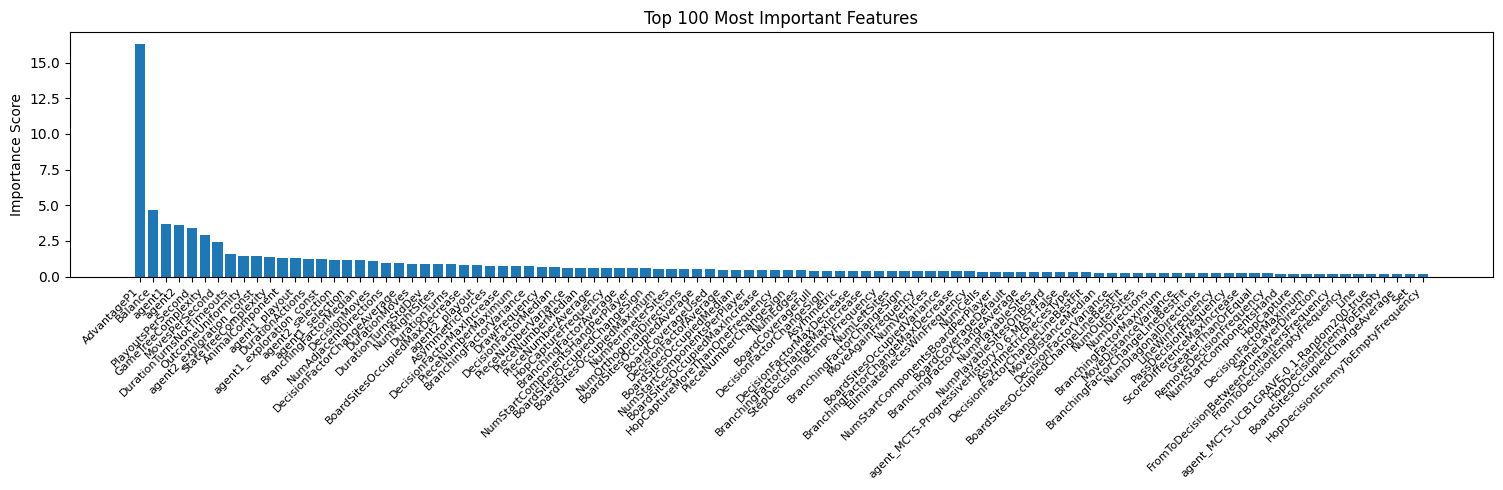

Fold 4 - RMSE: 0.43932403125043157
Fold 5


0:	learn: 0.6047135	test: 0.5858699	best: 0.5858699 (0)	total: 82.8ms	remaining: 4m 8s


50:	learn: 0.3825483	test: 0.4750686	best: 0.4750686 (50)	total: 5.09s	remaining: 4m 54s


100:	learn: 0.3475115	test: 0.4567702	best: 0.4567614 (99)	total: 10.6s	remaining: 5m 3s


150:	learn: 0.3246496	test: 0.4471914	best: 0.4471914 (150)	total: 16s	remaining: 5m 1s


200:	learn: 0.3088911	test: 0.4417312	best: 0.4417312 (200)	total: 21.4s	remaining: 4m 57s


250:	learn: 0.2972596	test: 0.4379818	best: 0.4379649 (249)	total: 26.9s	remaining: 4m 54s


300:	learn: 0.2884357	test: 0.4364842	best: 0.4364834 (299)	total: 32.4s	remaining: 4m 50s


350:	learn: 0.2798177	test: 0.4350042	best: 0.4350042 (350)	total: 37.9s	remaining: 4m 45s


400:	learn: 0.2731614	test: 0.4338634	best: 0.4338353 (397)	total: 43.3s	remaining: 4m 40s


450:	learn: 0.2668391	test: 0.4324676	best: 0.4324676 (450)	total: 48.8s	remaining: 4m 35s


500:	learn: 0.2615112	test: 0.4312733	best: 0.4312374 (499)	total: 54.3s	remaining: 4m 30s


550:	learn: 0.2561405	test: 0.4304726	best: 0.4304040 (546)	total: 59.8s	remaining: 4m 25s


600:	learn: 0.2513007	test: 0.4295170	best: 0.4295170 (600)	total: 1m 5s	remaining: 4m 21s


650:	learn: 0.2474028	test: 0.4293707	best: 0.4293170 (649)	total: 1m 10s	remaining: 4m 15s


700:	learn: 0.2436593	test: 0.4287888	best: 0.4287765 (698)	total: 1m 16s	remaining: 4m 10s


750:	learn: 0.2401304	test: 0.4283183	best: 0.4283183 (750)	total: 1m 21s	remaining: 4m 4s


800:	learn: 0.2368842	test: 0.4276271	best: 0.4276236 (797)	total: 1m 27s	remaining: 3m 59s


850:	learn: 0.2338961	test: 0.4272151	best: 0.4272151 (850)	total: 1m 32s	remaining: 3m 54s


900:	learn: 0.2309053	test: 0.4271446	best: 0.4270739 (884)	total: 1m 38s	remaining: 3m 49s


950:	learn: 0.2283456	test: 0.4271456	best: 0.4270674 (944)	total: 1m 44s	remaining: 3m 44s


1000:	learn: 0.2256806	test: 0.4269306	best: 0.4268947 (994)	total: 1m 49s	remaining: 3m 38s


1050:	learn: 0.2228471	test: 0.4267233	best: 0.4267233 (1050)	total: 1m 55s	remaining: 3m 33s


1100:	learn: 0.2203664	test: 0.4265254	best: 0.4265254 (1100)	total: 2m	remaining: 3m 28s


1150:	learn: 0.2180812	test: 0.4263906	best: 0.4263853 (1149)	total: 2m 6s	remaining: 3m 22s


1200:	learn: 0.2158997	test: 0.4260999	best: 0.4260999 (1200)	total: 2m 11s	remaining: 3m 17s


1250:	learn: 0.2140456	test: 0.4258058	best: 0.4258058 (1250)	total: 2m 17s	remaining: 3m 12s


1300:	learn: 0.2120312	test: 0.4255597	best: 0.4255597 (1300)	total: 2m 22s	remaining: 3m 6s


1350:	learn: 0.2100951	test: 0.4254314	best: 0.4254240 (1348)	total: 2m 28s	remaining: 3m 1s


1400:	learn: 0.2082764	test: 0.4252917	best: 0.4252917 (1400)	total: 2m 34s	remaining: 2m 55s


1450:	learn: 0.2065154	test: 0.4251680	best: 0.4251680 (1450)	total: 2m 39s	remaining: 2m 50s


1500:	learn: 0.2048554	test: 0.4249773	best: 0.4249773 (1500)	total: 2m 45s	remaining: 2m 45s


1550:	learn: 0.2032038	test: 0.4249886	best: 0.4249715 (1537)	total: 2m 51s	remaining: 2m 39s


1600:	learn: 0.2015287	test: 0.4248302	best: 0.4248118 (1593)	total: 2m 56s	remaining: 2m 34s


1650:	learn: 0.1998681	test: 0.4248024	best: 0.4247650 (1635)	total: 3m 2s	remaining: 2m 28s


1700:	learn: 0.1982034	test: 0.4247198	best: 0.4247198 (1700)	total: 3m 7s	remaining: 2m 23s


1750:	learn: 0.1966653	test: 0.4246767	best: 0.4246562 (1731)	total: 3m 13s	remaining: 2m 18s


1800:	learn: 0.1950193	test: 0.4247124	best: 0.4246562 (1731)	total: 3m 18s	remaining: 2m 12s


1850:	learn: 0.1935105	test: 0.4246680	best: 0.4246368 (1816)	total: 3m 24s	remaining: 2m 6s


1900:	learn: 0.1920200	test: 0.4246473	best: 0.4246368 (1816)	total: 3m 30s	remaining: 2m 1s


1950:	learn: 0.1906462	test: 0.4246862	best: 0.4246368 (1816)	total: 3m 35s	remaining: 1m 56s


2000:	learn: 0.1891357	test: 0.4246883	best: 0.4246368 (1816)	total: 3m 41s	remaining: 1m 50s


2050:	learn: 0.1877963	test: 0.4246960	best: 0.4246368 (1816)	total: 3m 47s	remaining: 1m 45s


2100:	learn: 0.1864638	test: 0.4247038	best: 0.4246368 (1816)	total: 3m 52s	remaining: 1m 39s


2150:	learn: 0.1850413	test: 0.4246850	best: 0.4246368 (1816)	total: 3m 58s	remaining: 1m 33s


2200:	learn: 0.1836910	test: 0.4246958	best: 0.4246368 (1816)	total: 4m 3s	remaining: 1m 28s


2250:	learn: 0.1822385	test: 0.4247362	best: 0.4246336 (2228)	total: 4m 9s	remaining: 1m 22s


2300:	learn: 0.1809651	test: 0.4246512	best: 0.4246336 (2228)	total: 4m 14s	remaining: 1m 17s


2350:	learn: 0.1797612	test: 0.4246018	best: 0.4245900 (2343)	total: 4m 20s	remaining: 1m 11s


2400:	learn: 0.1785681	test: 0.4246323	best: 0.4245900 (2343)	total: 4m 26s	remaining: 1m 6s


2450:	learn: 0.1772774	test: 0.4246175	best: 0.4245900 (2343)	total: 4m 31s	remaining: 1m


2500:	learn: 0.1761576	test: 0.4245865	best: 0.4245829 (2489)	total: 4m 37s	remaining: 55.4s


2550:	learn: 0.1750173	test: 0.4245308	best: 0.4245212 (2544)	total: 4m 43s	remaining: 49.8s


2600:	learn: 0.1738237	test: 0.4245188	best: 0.4244946 (2579)	total: 4m 48s	remaining: 44.3s


2650:	learn: 0.1727201	test: 0.4245492	best: 0.4244946 (2579)	total: 4m 54s	remaining: 38.8s


2700:	learn: 0.1717469	test: 0.4245572	best: 0.4244946 (2579)	total: 5m	remaining: 33.2s


2750:	learn: 0.1705792	test: 0.4245223	best: 0.4244946 (2579)	total: 5m 5s	remaining: 27.7s


2800:	learn: 0.1695371	test: 0.4244956	best: 0.4244864 (2795)	total: 5m 11s	remaining: 22.1s


2850:	learn: 0.1684351	test: 0.4244957	best: 0.4244548 (2829)	total: 5m 17s	remaining: 16.6s


2900:	learn: 0.1673375	test: 0.4244812	best: 0.4244548 (2829)	total: 5m 22s	remaining: 11s


2950:	learn: 0.1663831	test: 0.4244767	best: 0.4244548 (2829)	total: 5m 28s	remaining: 5.45s


2999:	learn: 0.1654008	test: 0.4244686	best: 0.4244517 (2992)	total: 5m 34s	remaining: 0us

bestTest = 0.4244517133
bestIteration = 2992

Shrink model to first 2993 iterations.


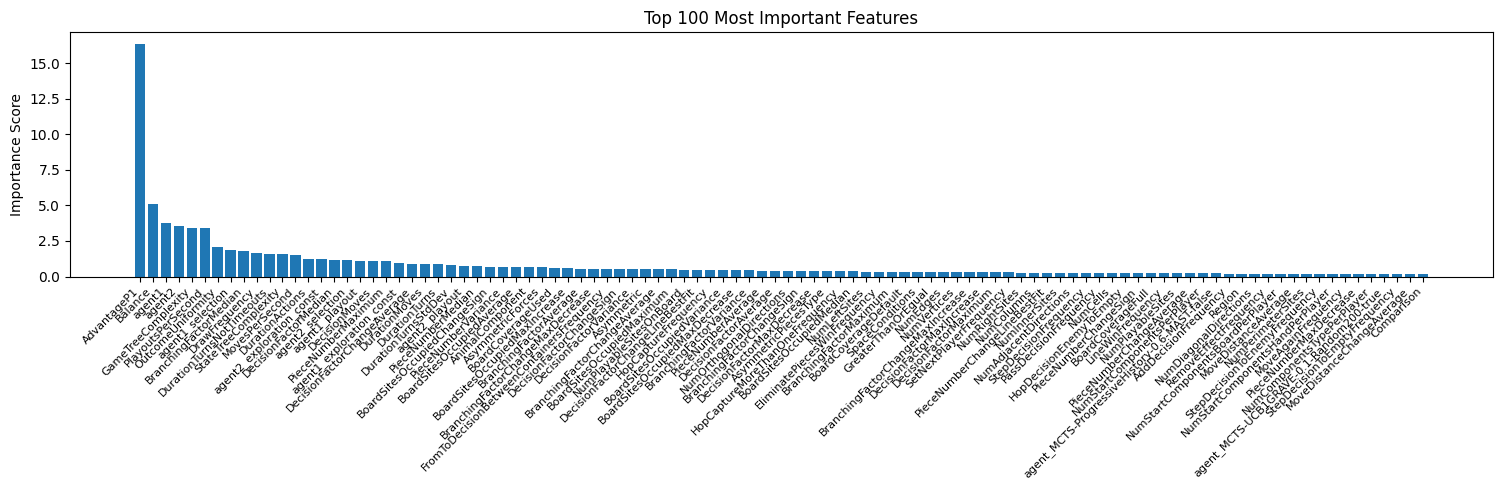

Fold 5 - RMSE: 0.42381694630568106
List of oof scores: [0.4112667694646939, 0.39951157754984146, 0.42442527828021775, 0.43932403125043157, 0.42381694630568106]
Average oof score: 0.41966892057017313


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6077452	test: 0.5677502	best: 0.5677502 (0)	total: 92.3ms	remaining: 4m 36s


50:	learn: 0.3907753	test: 0.4690995	best: 0.4690995 (50)	total: 5.49s	remaining: 5m 17s


100:	learn: 0.3513038	test: 0.4506145	best: 0.4506145 (100)	total: 11.1s	remaining: 5m 17s


150:	learn: 0.3272345	test: 0.4437688	best: 0.4437688 (150)	total: 16.6s	remaining: 5m 12s


200:	learn: 0.3100588	test: 0.4396687	best: 0.4396687 (200)	total: 22.1s	remaining: 5m 7s


250:	learn: 0.2984978	test: 0.4374127	best: 0.4373384 (249)	total: 27.6s	remaining: 5m 2s


300:	learn: 0.2880230	test: 0.4361219	best: 0.4359493 (298)	total: 33.1s	remaining: 4m 56s


350:	learn: 0.2802207	test: 0.4349126	best: 0.4349126 (350)	total: 38.7s	remaining: 4m 52s


400:	learn: 0.2726464	test: 0.4340959	best: 0.4340608 (397)	total: 44.2s	remaining: 4m 46s


450:	learn: 0.2664117	test: 0.4335683	best: 0.4334261 (448)	total: 49.8s	remaining: 4m 41s


500:	learn: 0.2609736	test: 0.4330528	best: 0.4330528 (500)	total: 55.4s	remaining: 4m 36s


550:	learn: 0.2563992	test: 0.4325609	best: 0.4325609 (550)	total: 1m 1s	remaining: 4m 31s


600:	learn: 0.2519929	test: 0.4316706	best: 0.4316696 (599)	total: 1m 6s	remaining: 4m 27s


650:	learn: 0.2475417	test: 0.4312810	best: 0.4312810 (650)	total: 1m 12s	remaining: 4m 21s


700:	learn: 0.2434527	test: 0.4308555	best: 0.4308369 (692)	total: 1m 17s	remaining: 4m 15s


750:	learn: 0.2402874	test: 0.4307328	best: 0.4306992 (734)	total: 1m 23s	remaining: 4m 9s


800:	learn: 0.2368691	test: 0.4304471	best: 0.4304299 (788)	total: 1m 28s	remaining: 4m 4s


850:	learn: 0.2339907	test: 0.4300355	best: 0.4300355 (850)	total: 1m 34s	remaining: 3m 58s


900:	learn: 0.2309443	test: 0.4298595	best: 0.4298557 (899)	total: 1m 40s	remaining: 3m 53s


950:	learn: 0.2285024	test: 0.4298251	best: 0.4298057 (910)	total: 1m 45s	remaining: 3m 47s


1000:	learn: 0.2257643	test: 0.4296370	best: 0.4296223 (997)	total: 1m 51s	remaining: 3m 42s


1050:	learn: 0.2232834	test: 0.4296877	best: 0.4296223 (997)	total: 1m 57s	remaining: 3m 37s


1100:	learn: 0.2209378	test: 0.4295852	best: 0.4295743 (1097)	total: 2m 3s	remaining: 3m 32s


1150:	learn: 0.2188182	test: 0.4295936	best: 0.4295264 (1109)	total: 2m 8s	remaining: 3m 26s


1200:	learn: 0.2166020	test: 0.4295169	best: 0.4294968 (1191)	total: 2m 14s	remaining: 3m 21s


1250:	learn: 0.2145383	test: 0.4294650	best: 0.4294248 (1239)	total: 2m 20s	remaining: 3m 16s


1300:	learn: 0.2124506	test: 0.4294413	best: 0.4293471 (1274)	total: 2m 26s	remaining: 3m 11s


1350:	learn: 0.2104910	test: 0.4294880	best: 0.4293471 (1274)	total: 2m 32s	remaining: 3m 5s


1400:	learn: 0.2087610	test: 0.4293933	best: 0.4293471 (1274)	total: 2m 38s	remaining: 3m


1450:	learn: 0.2069086	test: 0.4293533	best: 0.4293199 (1408)	total: 2m 43s	remaining: 2m 54s


1500:	learn: 0.2050992	test: 0.4292996	best: 0.4292746 (1495)	total: 2m 49s	remaining: 2m 49s


1550:	learn: 0.2033156	test: 0.4293304	best: 0.4292685 (1511)	total: 2m 55s	remaining: 2m 44s


1600:	learn: 0.2015932	test: 0.4292763	best: 0.4292685 (1511)	total: 3m 1s	remaining: 2m 38s


1650:	learn: 0.1999457	test: 0.4291889	best: 0.4291889 (1650)	total: 3m 7s	remaining: 2m 33s


1700:	learn: 0.1983336	test: 0.4292101	best: 0.4291575 (1658)	total: 3m 12s	remaining: 2m 27s


1750:	learn: 0.1968803	test: 0.4292310	best: 0.4291575 (1658)	total: 3m 18s	remaining: 2m 21s


1800:	learn: 0.1953143	test: 0.4292253	best: 0.4291561 (1773)	total: 3m 24s	remaining: 2m 16s


1850:	learn: 0.1936164	test: 0.4292095	best: 0.4291561 (1773)	total: 3m 29s	remaining: 2m 10s


1900:	learn: 0.1922548	test: 0.4291102	best: 0.4291001 (1889)	total: 3m 35s	remaining: 2m 4s


1950:	learn: 0.1906178	test: 0.4292104	best: 0.4291001 (1889)	total: 3m 41s	remaining: 1m 59s


2000:	learn: 0.1892526	test: 0.4290954	best: 0.4290954 (2000)	total: 3m 47s	remaining: 1m 53s


2050:	learn: 0.1878942	test: 0.4290519	best: 0.4290456 (2031)	total: 3m 53s	remaining: 1m 47s


2100:	learn: 0.1865636	test: 0.4290103	best: 0.4289932 (2093)	total: 3m 58s	remaining: 1m 42s


2150:	learn: 0.1852198	test: 0.4290212	best: 0.4289880 (2122)	total: 4m 4s	remaining: 1m 36s


2200:	learn: 0.1839592	test: 0.4290073	best: 0.4289880 (2122)	total: 4m 10s	remaining: 1m 30s


2250:	learn: 0.1826419	test: 0.4290660	best: 0.4289880 (2122)	total: 4m 16s	remaining: 1m 25s


2300:	learn: 0.1815821	test: 0.4290689	best: 0.4289880 (2122)	total: 4m 22s	remaining: 1m 19s


2350:	learn: 0.1803818	test: 0.4290848	best: 0.4289880 (2122)	total: 4m 27s	remaining: 1m 13s


2400:	learn: 0.1791670	test: 0.4290755	best: 0.4289880 (2122)	total: 4m 33s	remaining: 1m 8s


2450:	learn: 0.1780587	test: 0.4290080	best: 0.4289880 (2122)	total: 4m 39s	remaining: 1m 2s


2500:	learn: 0.1769583	test: 0.4290316	best: 0.4289880 (2122)	total: 4m 44s	remaining: 56.8s


2550:	learn: 0.1758264	test: 0.4290022	best: 0.4289880 (2122)	total: 4m 50s	remaining: 51.1s


2600:	learn: 0.1747220	test: 0.4289455	best: 0.4289373 (2593)	total: 4m 56s	remaining: 45.4s


2650:	learn: 0.1737205	test: 0.4289389	best: 0.4288998 (2625)	total: 5m 1s	remaining: 39.8s


2700:	learn: 0.1724651	test: 0.4289040	best: 0.4288840 (2689)	total: 5m 7s	remaining: 34s


2750:	learn: 0.1712402	test: 0.4288302	best: 0.4288253 (2747)	total: 5m 13s	remaining: 28.4s


2800:	learn: 0.1700382	test: 0.4288808	best: 0.4288253 (2747)	total: 5m 20s	remaining: 22.7s


2850:	learn: 0.1688999	test: 0.4288681	best: 0.4288253 (2747)	total: 5m 26s	remaining: 17.1s


2900:	learn: 0.1678577	test: 0.4288100	best: 0.4288056 (2899)	total: 5m 32s	remaining: 11.4s


2950:	learn: 0.1667899	test: 0.4288166	best: 0.4287913 (2932)	total: 5m 39s	remaining: 5.63s


2999:	learn: 0.1657401	test: 0.4287707	best: 0.4287652 (2995)	total: 5m 46s	remaining: 0us

bestTest = 0.4287651664
bestIteration = 2995

Shrink model to first 2996 iterations.


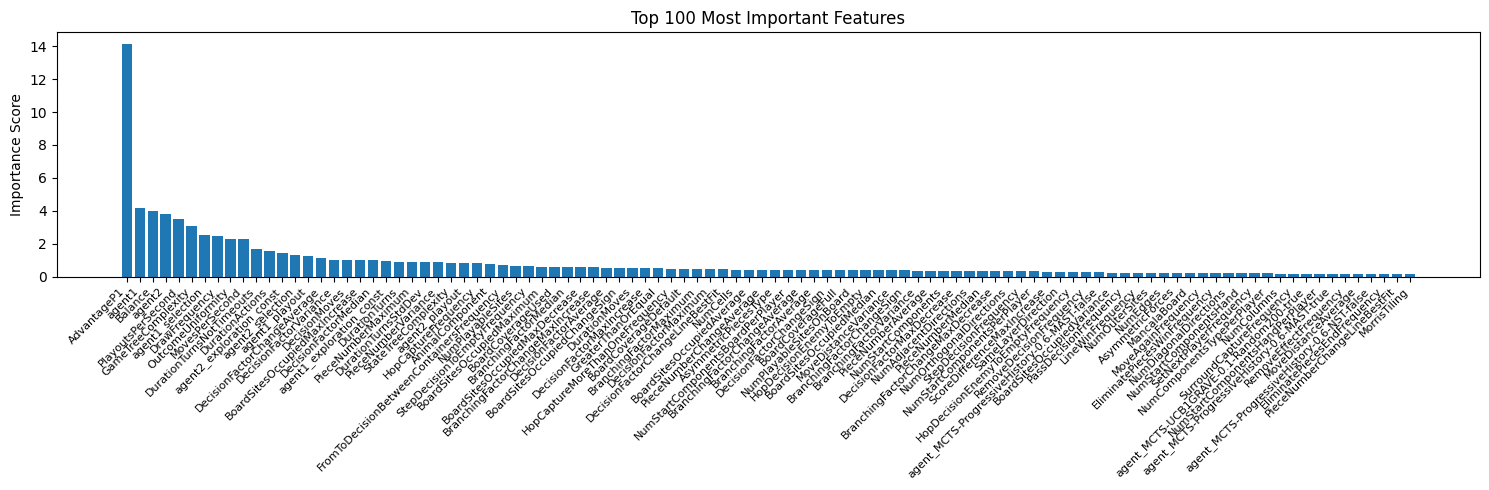

Fold 1 - RMSE: 0.4283396029148786
Fold 2


0:	learn: 0.6066302	test: 0.5694832	best: 0.5694832 (0)	total: 104ms	remaining: 5m 11s


50:	learn: 0.3878272	test: 0.4594860	best: 0.4594860 (50)	total: 6.23s	remaining: 6m


100:	learn: 0.3496353	test: 0.4381989	best: 0.4381989 (100)	total: 12.5s	remaining: 5m 57s


150:	learn: 0.3264516	test: 0.4280498	best: 0.4280498 (150)	total: 18.6s	remaining: 5m 50s


200:	learn: 0.3112213	test: 0.4220323	best: 0.4220323 (200)	total: 24.9s	remaining: 5m 46s


250:	learn: 0.2998332	test: 0.4190407	best: 0.4190407 (250)	total: 31.2s	remaining: 5m 42s


300:	learn: 0.2908246	test: 0.4163255	best: 0.4163255 (300)	total: 37.6s	remaining: 5m 37s


350:	learn: 0.2821569	test: 0.4147161	best: 0.4147161 (350)	total: 44s	remaining: 5m 32s


400:	learn: 0.2746411	test: 0.4136942	best: 0.4136942 (400)	total: 50.3s	remaining: 5m 26s


450:	learn: 0.2679087	test: 0.4123312	best: 0.4123312 (450)	total: 56.6s	remaining: 5m 20s


500:	learn: 0.2623243	test: 0.4115018	best: 0.4115018 (500)	total: 1m 3s	remaining: 5m 15s


550:	learn: 0.2571307	test: 0.4109900	best: 0.4109900 (550)	total: 1m 9s	remaining: 5m 9s


600:	learn: 0.2528672	test: 0.4103580	best: 0.4103580 (600)	total: 1m 16s	remaining: 5m 4s


650:	learn: 0.2488607	test: 0.4099661	best: 0.4099661 (650)	total: 1m 23s	remaining: 4m 59s


700:	learn: 0.2451337	test: 0.4090113	best: 0.4089799 (698)	total: 1m 29s	remaining: 4m 53s


750:	learn: 0.2416127	test: 0.4084879	best: 0.4084589 (741)	total: 1m 36s	remaining: 4m 48s


800:	learn: 0.2382424	test: 0.4078963	best: 0.4078963 (800)	total: 1m 42s	remaining: 4m 42s


850:	learn: 0.2349045	test: 0.4073706	best: 0.4073654 (848)	total: 1m 49s	remaining: 4m 36s


900:	learn: 0.2319787	test: 0.4070628	best: 0.4070545 (897)	total: 1m 56s	remaining: 4m 30s


950:	learn: 0.2294322	test: 0.4066951	best: 0.4066951 (950)	total: 2m 2s	remaining: 4m 24s


1000:	learn: 0.2266606	test: 0.4063710	best: 0.4063710 (1000)	total: 2m 9s	remaining: 4m 18s


1050:	learn: 0.2240737	test: 0.4060582	best: 0.4060488 (1045)	total: 2m 16s	remaining: 4m 12s


1100:	learn: 0.2216075	test: 0.4057685	best: 0.4057685 (1100)	total: 2m 22s	remaining: 4m 6s


1150:	learn: 0.2193001	test: 0.4055481	best: 0.4055481 (1150)	total: 2m 29s	remaining: 4m


1200:	learn: 0.2172015	test: 0.4056086	best: 0.4055481 (1150)	total: 2m 36s	remaining: 3m 54s


1250:	learn: 0.2151138	test: 0.4054563	best: 0.4054563 (1250)	total: 2m 43s	remaining: 3m 48s


1300:	learn: 0.2129135	test: 0.4051784	best: 0.4051714 (1298)	total: 2m 50s	remaining: 3m 42s


1350:	learn: 0.2109950	test: 0.4050513	best: 0.4050503 (1349)	total: 2m 57s	remaining: 3m 36s


1400:	learn: 0.2089940	test: 0.4050055	best: 0.4049825 (1359)	total: 3m 4s	remaining: 3m 30s


1450:	learn: 0.2073110	test: 0.4047990	best: 0.4047925 (1447)	total: 3m 10s	remaining: 3m 23s


1500:	learn: 0.2054917	test: 0.4047464	best: 0.4047464 (1500)	total: 3m 17s	remaining: 3m 17s


1550:	learn: 0.2038479	test: 0.4046587	best: 0.4046466 (1532)	total: 3m 24s	remaining: 3m 11s


1600:	learn: 0.2021709	test: 0.4046170	best: 0.4046050 (1597)	total: 3m 31s	remaining: 3m 4s


1650:	learn: 0.2004983	test: 0.4044805	best: 0.4044685 (1643)	total: 3m 38s	remaining: 2m 58s


1700:	learn: 0.1989998	test: 0.4044220	best: 0.4044220 (1700)	total: 3m 45s	remaining: 2m 51s


1750:	learn: 0.1975213	test: 0.4043657	best: 0.4043401 (1746)	total: 3m 51s	remaining: 2m 45s


1800:	learn: 0.1959382	test: 0.4042165	best: 0.4042106 (1799)	total: 3m 58s	remaining: 2m 38s


1850:	learn: 0.1943674	test: 0.4041966	best: 0.4041889 (1804)	total: 4m 5s	remaining: 2m 32s


1900:	learn: 0.1930687	test: 0.4041408	best: 0.4041401 (1889)	total: 4m 12s	remaining: 2m 25s


1950:	learn: 0.1915695	test: 0.4042086	best: 0.4041401 (1889)	total: 4m 19s	remaining: 2m 19s


2000:	learn: 0.1901312	test: 0.4041364	best: 0.4041364 (2000)	total: 4m 25s	remaining: 2m 12s


2050:	learn: 0.1887420	test: 0.4041158	best: 0.4040950 (2036)	total: 4m 32s	remaining: 2m 6s


2100:	learn: 0.1872928	test: 0.4041113	best: 0.4040679 (2073)	total: 4m 39s	remaining: 1m 59s


2150:	learn: 0.1859042	test: 0.4040374	best: 0.4040241 (2147)	total: 4m 46s	remaining: 1m 52s


2200:	learn: 0.1845555	test: 0.4040231	best: 0.4039554 (2172)	total: 4m 52s	remaining: 1m 46s


2250:	learn: 0.1831352	test: 0.4040526	best: 0.4039554 (2172)	total: 4m 59s	remaining: 1m 39s


2300:	learn: 0.1818952	test: 0.4040316	best: 0.4039554 (2172)	total: 5m 6s	remaining: 1m 33s


2350:	learn: 0.1807019	test: 0.4040645	best: 0.4039554 (2172)	total: 5m 13s	remaining: 1m 26s


2400:	learn: 0.1794603	test: 0.4040962	best: 0.4039554 (2172)	total: 5m 19s	remaining: 1m 19s


2450:	learn: 0.1782619	test: 0.4041192	best: 0.4039554 (2172)	total: 5m 26s	remaining: 1m 13s


2500:	learn: 0.1771109	test: 0.4041026	best: 0.4039554 (2172)	total: 5m 33s	remaining: 1m 6s


2550:	learn: 0.1759471	test: 0.4041016	best: 0.4039554 (2172)	total: 5m 40s	remaining: 59.9s


2600:	learn: 0.1747093	test: 0.4041234	best: 0.4039554 (2172)	total: 5m 46s	remaining: 53.2s


2650:	learn: 0.1735610	test: 0.4041049	best: 0.4039554 (2172)	total: 5m 53s	remaining: 46.5s


2700:	learn: 0.1724712	test: 0.4040177	best: 0.4039554 (2172)	total: 6m	remaining: 39.9s


2750:	learn: 0.1713655	test: 0.4040419	best: 0.4039554 (2172)	total: 6m 7s	remaining: 33.2s


2800:	learn: 0.1703177	test: 0.4039744	best: 0.4039554 (2172)	total: 6m 13s	remaining: 26.5s


2850:	learn: 0.1693313	test: 0.4039838	best: 0.4039554 (2172)	total: 6m 20s	remaining: 19.9s


2900:	learn: 0.1682406	test: 0.4039951	best: 0.4039554 (2172)	total: 6m 26s	remaining: 13.2s


2950:	learn: 0.1672279	test: 0.4040099	best: 0.4039554 (2172)	total: 6m 33s	remaining: 6.53s


2999:	learn: 0.1661962	test: 0.4039833	best: 0.4039554 (2172)	total: 6m 40s	remaining: 0us

bestTest = 0.4039554126
bestIteration = 2172

Shrink model to first 2173 iterations.


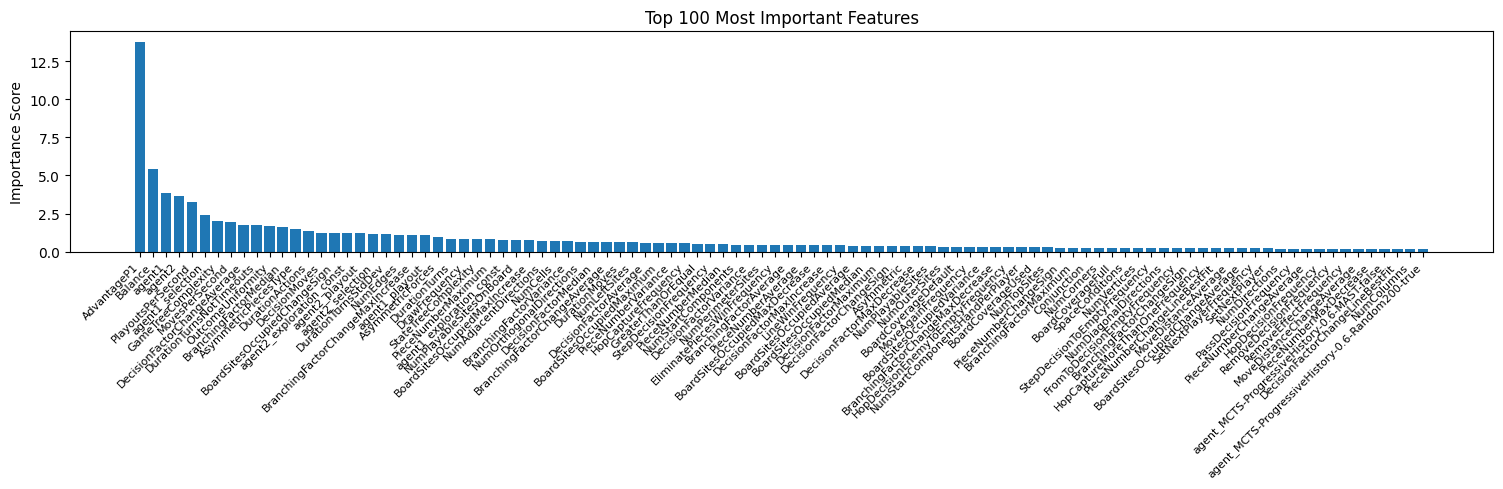

Fold 2 - RMSE: 0.40361248197359584
Fold 3


0:	learn: 0.6110156	test: 0.5690267	best: 0.5690267 (0)	total: 106ms	remaining: 5m 16s


50:	learn: 0.3889814	test: 0.4591596	best: 0.4591596 (50)	total: 6.27s	remaining: 6m 2s


100:	learn: 0.3463047	test: 0.4406280	best: 0.4406280 (100)	total: 12.6s	remaining: 6m 2s


150:	learn: 0.3224020	test: 0.4321168	best: 0.4321168 (150)	total: 19s	remaining: 5m 59s


200:	learn: 0.3078742	test: 0.4278930	best: 0.4278930 (200)	total: 25.4s	remaining: 5m 54s


250:	learn: 0.2966651	test: 0.4254271	best: 0.4254271 (250)	total: 31.9s	remaining: 5m 49s


300:	learn: 0.2879988	test: 0.4232638	best: 0.4232638 (300)	total: 38.4s	remaining: 5m 44s


350:	learn: 0.2805911	test: 0.4216795	best: 0.4216795 (350)	total: 44.8s	remaining: 5m 38s


400:	learn: 0.2732970	test: 0.4204695	best: 0.4204695 (400)	total: 51.1s	remaining: 5m 31s


450:	learn: 0.2675409	test: 0.4198108	best: 0.4198108 (450)	total: 57.4s	remaining: 5m 24s


500:	learn: 0.2621635	test: 0.4192639	best: 0.4192539 (499)	total: 1m 3s	remaining: 5m 18s


550:	learn: 0.2571585	test: 0.4186715	best: 0.4186715 (550)	total: 1m 10s	remaining: 5m 12s


600:	learn: 0.2525491	test: 0.4182019	best: 0.4182019 (600)	total: 1m 16s	remaining: 5m 5s


650:	learn: 0.2480806	test: 0.4178356	best: 0.4178072 (649)	total: 1m 23s	remaining: 4m 59s


700:	learn: 0.2439454	test: 0.4173179	best: 0.4172966 (697)	total: 1m 29s	remaining: 4m 52s


750:	learn: 0.2403672	test: 0.4169812	best: 0.4169795 (749)	total: 1m 35s	remaining: 4m 46s


800:	learn: 0.2370673	test: 0.4165424	best: 0.4165344 (798)	total: 1m 42s	remaining: 4m 40s


850:	learn: 0.2341316	test: 0.4161758	best: 0.4161655 (841)	total: 1m 48s	remaining: 4m 34s


900:	learn: 0.2311612	test: 0.4158919	best: 0.4158822 (898)	total: 1m 55s	remaining: 4m 28s


950:	learn: 0.2282986	test: 0.4156785	best: 0.4156539 (948)	total: 2m 1s	remaining: 4m 21s


1000:	learn: 0.2256700	test: 0.4154651	best: 0.4154358 (998)	total: 2m 7s	remaining: 4m 15s


1050:	learn: 0.2231539	test: 0.4151932	best: 0.4151849 (1048)	total: 2m 14s	remaining: 4m 9s


1100:	learn: 0.2206856	test: 0.4148696	best: 0.4148690 (1099)	total: 2m 20s	remaining: 4m 2s


1150:	learn: 0.2181896	test: 0.4145754	best: 0.4145378 (1142)	total: 2m 26s	remaining: 3m 56s


1200:	learn: 0.2158020	test: 0.4145018	best: 0.4144847 (1174)	total: 2m 33s	remaining: 3m 49s


1250:	learn: 0.2137700	test: 0.4143327	best: 0.4143327 (1250)	total: 2m 40s	remaining: 3m 43s


1300:	learn: 0.2116661	test: 0.4142399	best: 0.4142399 (1300)	total: 2m 46s	remaining: 3m 37s


1350:	learn: 0.2097805	test: 0.4141963	best: 0.4141874 (1348)	total: 2m 53s	remaining: 3m 31s


1400:	learn: 0.2078122	test: 0.4141487	best: 0.4141419 (1390)	total: 2m 59s	remaining: 3m 24s


1450:	learn: 0.2059574	test: 0.4141441	best: 0.4141273 (1403)	total: 3m 5s	remaining: 3m 18s


1500:	learn: 0.2041227	test: 0.4139342	best: 0.4139342 (1500)	total: 3m 12s	remaining: 3m 12s


1550:	learn: 0.2023569	test: 0.4138328	best: 0.4138318 (1547)	total: 3m 18s	remaining: 3m 5s


1600:	learn: 0.2004303	test: 0.4136683	best: 0.4136683 (1600)	total: 3m 25s	remaining: 2m 59s


1650:	learn: 0.1987620	test: 0.4136411	best: 0.4136319 (1631)	total: 3m 31s	remaining: 2m 52s


1700:	learn: 0.1970930	test: 0.4135910	best: 0.4135746 (1689)	total: 3m 37s	remaining: 2m 46s


1750:	learn: 0.1953336	test: 0.4135089	best: 0.4135048 (1745)	total: 3m 44s	remaining: 2m 40s


1800:	learn: 0.1937768	test: 0.4134300	best: 0.4134149 (1792)	total: 3m 50s	remaining: 2m 33s


1850:	learn: 0.1923024	test: 0.4134129	best: 0.4133934 (1848)	total: 3m 57s	remaining: 2m 27s


1900:	learn: 0.1909488	test: 0.4133513	best: 0.4133436 (1893)	total: 4m 3s	remaining: 2m 20s


1950:	learn: 0.1894387	test: 0.4133748	best: 0.4133436 (1893)	total: 4m 9s	remaining: 2m 14s


2000:	learn: 0.1879173	test: 0.4132960	best: 0.4132947 (1997)	total: 4m 16s	remaining: 2m 8s


2050:	learn: 0.1865653	test: 0.4132972	best: 0.4132811 (2007)	total: 4m 22s	remaining: 2m 1s


2100:	learn: 0.1850526	test: 0.4132773	best: 0.4132691 (2064)	total: 4m 29s	remaining: 1m 55s


2150:	learn: 0.1836445	test: 0.4131966	best: 0.4131863 (2143)	total: 4m 35s	remaining: 1m 48s


2200:	learn: 0.1823511	test: 0.4131511	best: 0.4131501 (2199)	total: 4m 41s	remaining: 1m 42s


2250:	learn: 0.1809728	test: 0.4131877	best: 0.4131448 (2209)	total: 4m 48s	remaining: 1m 35s


2300:	learn: 0.1796824	test: 0.4131148	best: 0.4131148 (2300)	total: 4m 54s	remaining: 1m 29s


2350:	learn: 0.1783445	test: 0.4130752	best: 0.4130601 (2318)	total: 5m 1s	remaining: 1m 23s


2400:	learn: 0.1771473	test: 0.4130341	best: 0.4130316 (2396)	total: 5m 7s	remaining: 1m 16s


2450:	learn: 0.1758336	test: 0.4129802	best: 0.4129802 (2450)	total: 5m 13s	remaining: 1m 10s


2500:	learn: 0.1745730	test: 0.4129603	best: 0.4129520 (2482)	total: 5m 20s	remaining: 1m 3s


2550:	learn: 0.1733025	test: 0.4129676	best: 0.4129433 (2525)	total: 5m 26s	remaining: 57.5s


2600:	learn: 0.1720758	test: 0.4130425	best: 0.4129409 (2558)	total: 5m 33s	remaining: 51.1s


2650:	learn: 0.1708613	test: 0.4131030	best: 0.4129409 (2558)	total: 5m 39s	remaining: 44.7s


2700:	learn: 0.1696572	test: 0.4130329	best: 0.4129409 (2558)	total: 5m 45s	remaining: 38.2s


2750:	learn: 0.1683750	test: 0.4129544	best: 0.4129409 (2558)	total: 5m 51s	remaining: 31.8s


2800:	learn: 0.1672107	test: 0.4129051	best: 0.4129014 (2769)	total: 5m 58s	remaining: 25.4s


2850:	learn: 0.1661586	test: 0.4129105	best: 0.4128693 (2826)	total: 6m 4s	remaining: 19s


2900:	learn: 0.1650376	test: 0.4128752	best: 0.4128672 (2895)	total: 6m 10s	remaining: 12.7s


2950:	learn: 0.1638931	test: 0.4129094	best: 0.4128672 (2895)	total: 6m 17s	remaining: 6.26s


2999:	learn: 0.1627965	test: 0.4129084	best: 0.4128672 (2895)	total: 6m 24s	remaining: 0us

bestTest = 0.412867185
bestIteration = 2895

Shrink model to first 2896 iterations.


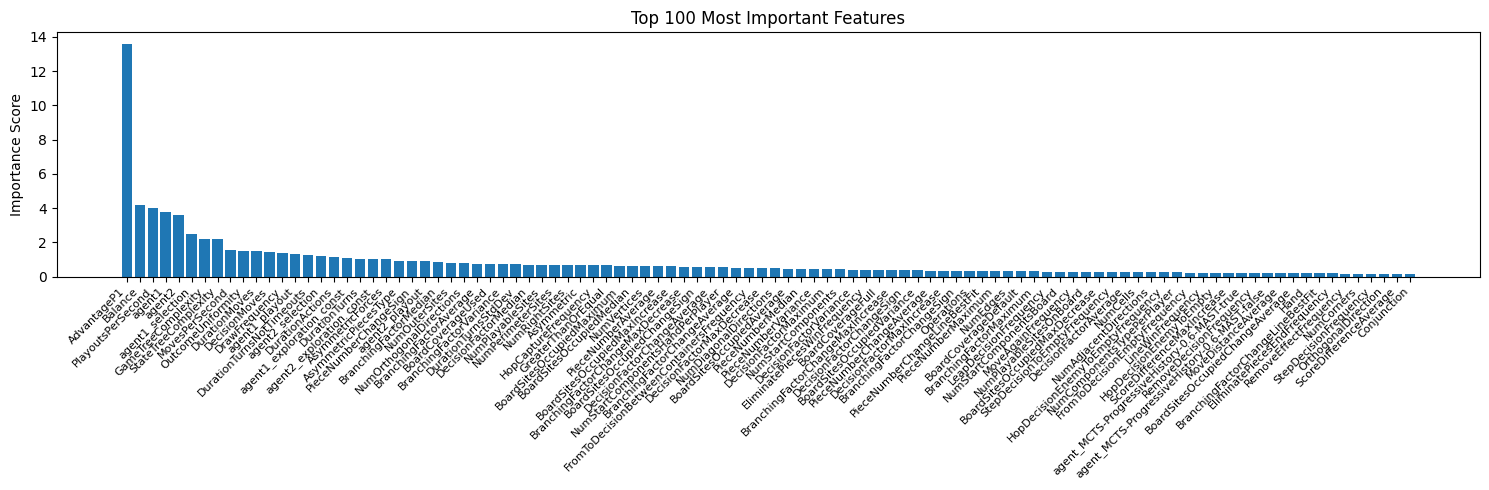

Fold 3 - RMSE: 0.4124303727445388
Fold 4


0:	learn: 0.6099866	test: 0.5674581	best: 0.5674581 (0)	total: 120ms	remaining: 5m 58s


50:	learn: 0.3885563	test: 0.4533082	best: 0.4533082 (50)	total: 6.42s	remaining: 6m 11s


100:	learn: 0.3513250	test: 0.4378750	best: 0.4378750 (100)	total: 13s	remaining: 6m 13s


150:	learn: 0.3261980	test: 0.4313911	best: 0.4312278 (148)	total: 19.3s	remaining: 6m 4s


200:	learn: 0.3101620	test: 0.4274781	best: 0.4274781 (200)	total: 25.6s	remaining: 5m 55s


250:	learn: 0.2974027	test: 0.4248271	best: 0.4248028 (249)	total: 32s	remaining: 5m 50s


300:	learn: 0.2876136	test: 0.4231176	best: 0.4231176 (300)	total: 38.3s	remaining: 5m 43s


350:	learn: 0.2801043	test: 0.4216516	best: 0.4216300 (348)	total: 44.7s	remaining: 5m 36s


400:	learn: 0.2734669	test: 0.4201375	best: 0.4201361 (399)	total: 51s	remaining: 5m 30s


450:	learn: 0.2670317	test: 0.4191096	best: 0.4190878 (447)	total: 57.4s	remaining: 5m 24s


500:	learn: 0.2612507	test: 0.4184176	best: 0.4184061 (499)	total: 1m 3s	remaining: 5m 17s


550:	learn: 0.2562273	test: 0.4182057	best: 0.4181919 (549)	total: 1m 10s	remaining: 5m 11s


600:	learn: 0.2515818	test: 0.4180824	best: 0.4180824 (600)	total: 1m 16s	remaining: 5m 5s


650:	learn: 0.2476261	test: 0.4178840	best: 0.4178227 (643)	total: 1m 22s	remaining: 4m 59s


700:	learn: 0.2440089	test: 0.4177141	best: 0.4175659 (688)	total: 1m 29s	remaining: 4m 52s


750:	learn: 0.2407816	test: 0.4174042	best: 0.4173796 (747)	total: 1m 35s	remaining: 4m 47s


800:	learn: 0.2376459	test: 0.4170851	best: 0.4170851 (800)	total: 1m 42s	remaining: 4m 40s


850:	learn: 0.2345443	test: 0.4170158	best: 0.4169581 (836)	total: 1m 48s	remaining: 4m 33s


900:	learn: 0.2313343	test: 0.4166736	best: 0.4166736 (900)	total: 1m 54s	remaining: 4m 27s


950:	learn: 0.2286023	test: 0.4165596	best: 0.4165583 (948)	total: 2m 1s	remaining: 4m 21s


1000:	learn: 0.2259237	test: 0.4164943	best: 0.4164933 (980)	total: 2m 7s	remaining: 4m 15s


1050:	learn: 0.2235859	test: 0.4161529	best: 0.4161529 (1050)	total: 2m 14s	remaining: 4m 8s


1100:	learn: 0.2213179	test: 0.4159986	best: 0.4159848 (1093)	total: 2m 20s	remaining: 4m 2s


1150:	learn: 0.2191795	test: 0.4160076	best: 0.4159609 (1134)	total: 2m 27s	remaining: 3m 56s


1200:	learn: 0.2172322	test: 0.4159251	best: 0.4158777 (1173)	total: 2m 33s	remaining: 3m 50s


1250:	learn: 0.2151872	test: 0.4157784	best: 0.4157784 (1250)	total: 2m 40s	remaining: 3m 44s


1300:	learn: 0.2133319	test: 0.4158315	best: 0.4157784 (1250)	total: 2m 46s	remaining: 3m 37s


1350:	learn: 0.2113498	test: 0.4156976	best: 0.4156948 (1344)	total: 2m 53s	remaining: 3m 31s


1400:	learn: 0.2091960	test: 0.4156179	best: 0.4156179 (1400)	total: 3m	remaining: 3m 25s


1450:	learn: 0.2072741	test: 0.4156130	best: 0.4156067 (1442)	total: 3m 6s	remaining: 3m 19s


1500:	learn: 0.2055177	test: 0.4156205	best: 0.4155442 (1466)	total: 3m 13s	remaining: 3m 13s


1550:	learn: 0.2039228	test: 0.4156229	best: 0.4155442 (1466)	total: 3m 20s	remaining: 3m 6s


1600:	learn: 0.2023925	test: 0.4156014	best: 0.4155442 (1466)	total: 3m 26s	remaining: 3m


1650:	learn: 0.2007260	test: 0.4154496	best: 0.4154480 (1648)	total: 3m 33s	remaining: 2m 54s


1700:	learn: 0.1989389	test: 0.4152136	best: 0.4152055 (1696)	total: 3m 39s	remaining: 2m 47s


1750:	learn: 0.1970688	test: 0.4151768	best: 0.4151711 (1749)	total: 3m 46s	remaining: 2m 41s


1800:	learn: 0.1956877	test: 0.4151378	best: 0.4151292 (1799)	total: 3m 53s	remaining: 2m 35s


1850:	learn: 0.1941003	test: 0.4151828	best: 0.4151292 (1799)	total: 3m 59s	remaining: 2m 28s


1900:	learn: 0.1924549	test: 0.4152789	best: 0.4151292 (1799)	total: 4m 6s	remaining: 2m 22s


1950:	learn: 0.1909459	test: 0.4152100	best: 0.4151292 (1799)	total: 4m 12s	remaining: 2m 15s


2000:	learn: 0.1895025	test: 0.4153015	best: 0.4151292 (1799)	total: 4m 19s	remaining: 2m 9s


2050:	learn: 0.1880982	test: 0.4152692	best: 0.4151292 (1799)	total: 4m 25s	remaining: 2m 3s


2100:	learn: 0.1868077	test: 0.4152617	best: 0.4151292 (1799)	total: 4m 32s	remaining: 1m 56s


2150:	learn: 0.1853739	test: 0.4153030	best: 0.4151292 (1799)	total: 4m 39s	remaining: 1m 50s


2200:	learn: 0.1840429	test: 0.4152255	best: 0.4151292 (1799)	total: 4m 45s	remaining: 1m 43s


2250:	learn: 0.1827184	test: 0.4152349	best: 0.4151292 (1799)	total: 4m 52s	remaining: 1m 37s


2300:	learn: 0.1814441	test: 0.4152370	best: 0.4151292 (1799)	total: 4m 58s	remaining: 1m 30s


2350:	learn: 0.1801938	test: 0.4152410	best: 0.4151292 (1799)	total: 5m 5s	remaining: 1m 24s


2400:	learn: 0.1788444	test: 0.4152425	best: 0.4151292 (1799)	total: 5m 11s	remaining: 1m 17s


2450:	learn: 0.1774841	test: 0.4152247	best: 0.4151292 (1799)	total: 5m 18s	remaining: 1m 11s


2500:	learn: 0.1763453	test: 0.4151494	best: 0.4151292 (1799)	total: 5m 25s	remaining: 1m 4s


2550:	learn: 0.1751220	test: 0.4151200	best: 0.4151143 (2547)	total: 5m 31s	remaining: 58.4s


2600:	learn: 0.1739389	test: 0.4151086	best: 0.4150912 (2558)	total: 5m 38s	remaining: 51.9s


2650:	learn: 0.1726956	test: 0.4150901	best: 0.4150843 (2644)	total: 5m 44s	remaining: 45.4s


2700:	learn: 0.1714859	test: 0.4150144	best: 0.4149764 (2683)	total: 5m 51s	remaining: 38.9s


2750:	learn: 0.1703584	test: 0.4150132	best: 0.4149764 (2683)	total: 5m 57s	remaining: 32.4s


2800:	learn: 0.1692763	test: 0.4150012	best: 0.4149764 (2683)	total: 6m 4s	remaining: 25.9s


2850:	learn: 0.1680851	test: 0.4151010	best: 0.4149764 (2683)	total: 6m 11s	remaining: 19.4s


2900:	learn: 0.1670779	test: 0.4150959	best: 0.4149764 (2683)	total: 6m 17s	remaining: 12.9s


2950:	learn: 0.1659753	test: 0.4151077	best: 0.4149764 (2683)	total: 6m 23s	remaining: 6.38s


2999:	learn: 0.1649879	test: 0.4150736	best: 0.4149764 (2683)	total: 6m 30s	remaining: 0us

bestTest = 0.4149764182
bestIteration = 2683

Shrink model to first 2684 iterations.


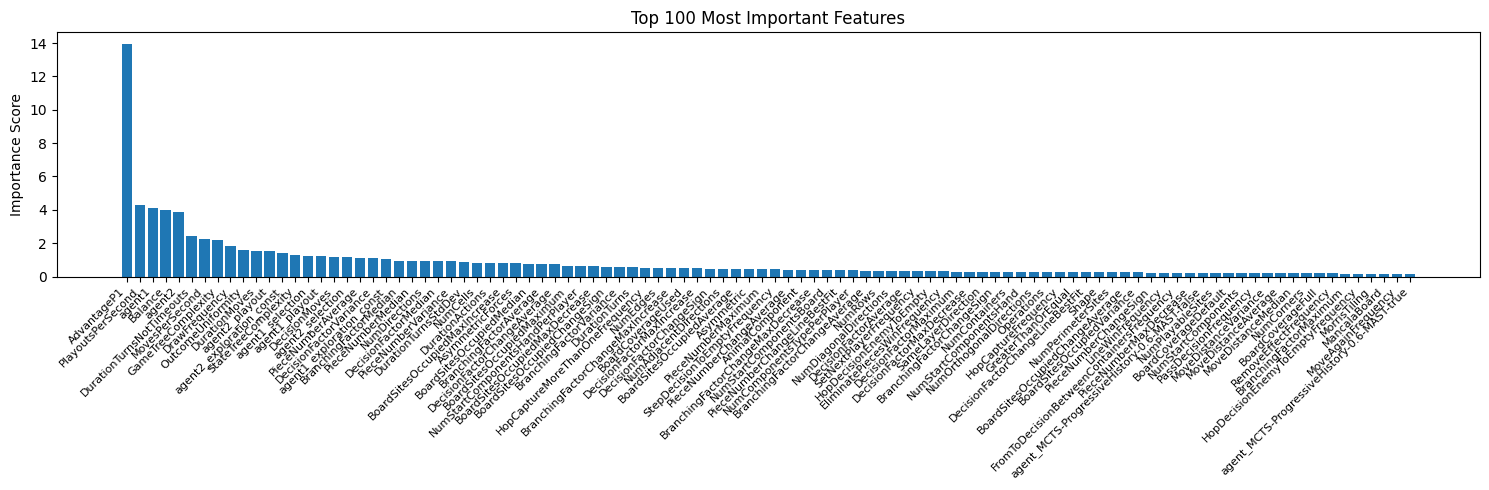

Fold 4 - RMSE: 0.41414411377938143
Fold 5


0:	learn: 0.6053503	test: 0.5809042	best: 0.5809042 (0)	total: 110ms	remaining: 5m 29s


50:	learn: 0.3897139	test: 0.4752137	best: 0.4752137 (50)	total: 6.43s	remaining: 6m 11s


100:	learn: 0.3507395	test: 0.4572371	best: 0.4572371 (100)	total: 13.1s	remaining: 6m 15s


150:	learn: 0.3276998	test: 0.4479940	best: 0.4479940 (150)	total: 19.6s	remaining: 6m 10s


200:	learn: 0.3116284	test: 0.4428283	best: 0.4428283 (200)	total: 26.1s	remaining: 6m 3s


250:	learn: 0.3001081	test: 0.4406868	best: 0.4406868 (250)	total: 32.8s	remaining: 5m 59s


300:	learn: 0.2903729	test: 0.4380919	best: 0.4380723 (299)	total: 39.3s	remaining: 5m 52s


350:	learn: 0.2821078	test: 0.4363347	best: 0.4363226 (347)	total: 45.8s	remaining: 5m 45s


400:	learn: 0.2750400	test: 0.4351569	best: 0.4351569 (400)	total: 52.3s	remaining: 5m 39s


450:	learn: 0.2689316	test: 0.4340228	best: 0.4340228 (450)	total: 58.9s	remaining: 5m 33s


500:	learn: 0.2636263	test: 0.4334151	best: 0.4334151 (500)	total: 1m 5s	remaining: 5m 27s


550:	learn: 0.2586365	test: 0.4329287	best: 0.4329287 (550)	total: 1m 12s	remaining: 5m 21s


600:	learn: 0.2537778	test: 0.4321451	best: 0.4321451 (600)	total: 1m 18s	remaining: 5m 14s


650:	learn: 0.2490277	test: 0.4315419	best: 0.4315414 (649)	total: 1m 25s	remaining: 5m 7s


700:	learn: 0.2452110	test: 0.4313474	best: 0.4312174 (688)	total: 1m 31s	remaining: 5m


750:	learn: 0.2414967	test: 0.4308430	best: 0.4308401 (747)	total: 1m 38s	remaining: 4m 54s


800:	learn: 0.2382747	test: 0.4305299	best: 0.4304928 (786)	total: 1m 44s	remaining: 4m 47s


850:	learn: 0.2353065	test: 0.4303002	best: 0.4302997 (848)	total: 1m 51s	remaining: 4m 41s


900:	learn: 0.2325288	test: 0.4300272	best: 0.4299861 (899)	total: 1m 57s	remaining: 4m 34s


950:	learn: 0.2296267	test: 0.4297406	best: 0.4297052 (944)	total: 2m 4s	remaining: 4m 28s


1000:	learn: 0.2269738	test: 0.4293647	best: 0.4293566 (999)	total: 2m 11s	remaining: 4m 21s


1050:	learn: 0.2244427	test: 0.4292621	best: 0.4292621 (1050)	total: 2m 17s	remaining: 4m 15s


1100:	learn: 0.2220822	test: 0.4290924	best: 0.4290764 (1094)	total: 2m 24s	remaining: 4m 8s


1150:	learn: 0.2194794	test: 0.4289812	best: 0.4289812 (1150)	total: 2m 30s	remaining: 4m 2s


1200:	learn: 0.2173733	test: 0.4289717	best: 0.4289246 (1159)	total: 2m 37s	remaining: 3m 55s


1250:	learn: 0.2153386	test: 0.4288503	best: 0.4288489 (1243)	total: 2m 44s	remaining: 3m 49s


1300:	learn: 0.2132097	test: 0.4287032	best: 0.4286970 (1299)	total: 2m 50s	remaining: 3m 42s


1350:	learn: 0.2111117	test: 0.4285208	best: 0.4285207 (1346)	total: 2m 57s	remaining: 3m 36s


1400:	learn: 0.2092538	test: 0.4284343	best: 0.4284260 (1395)	total: 3m 5s	remaining: 3m 31s


1450:	learn: 0.2074264	test: 0.4283226	best: 0.4283189 (1449)	total: 3m 12s	remaining: 3m 25s


1500:	learn: 0.2057313	test: 0.4282002	best: 0.4281912 (1497)	total: 3m 19s	remaining: 3m 18s


1550:	learn: 0.2038109	test: 0.4281322	best: 0.4281066 (1545)	total: 3m 25s	remaining: 3m 12s


1600:	learn: 0.2018963	test: 0.4280556	best: 0.4279837 (1593)	total: 3m 32s	remaining: 3m 5s


1650:	learn: 0.2003849	test: 0.4279907	best: 0.4279837 (1593)	total: 3m 38s	remaining: 2m 58s


1700:	learn: 0.1987614	test: 0.4279767	best: 0.4279298 (1678)	total: 3m 44s	remaining: 2m 51s


1750:	learn: 0.1971414	test: 0.4279625	best: 0.4279298 (1678)	total: 3m 51s	remaining: 2m 45s


1800:	learn: 0.1955561	test: 0.4279027	best: 0.4278823 (1766)	total: 3m 58s	remaining: 2m 38s


1850:	learn: 0.1939389	test: 0.4278955	best: 0.4278690 (1836)	total: 4m 4s	remaining: 2m 31s


1900:	learn: 0.1923900	test: 0.4278438	best: 0.4278438 (1900)	total: 4m 11s	remaining: 2m 25s


1950:	learn: 0.1908882	test: 0.4277551	best: 0.4277435 (1942)	total: 4m 17s	remaining: 2m 18s


2000:	learn: 0.1895891	test: 0.4277354	best: 0.4277163 (1977)	total: 4m 24s	remaining: 2m 12s


2050:	learn: 0.1881098	test: 0.4276288	best: 0.4276183 (2040)	total: 4m 31s	remaining: 2m 5s


2100:	learn: 0.1867226	test: 0.4276083	best: 0.4275964 (2060)	total: 4m 37s	remaining: 1m 58s


2150:	learn: 0.1854146	test: 0.4276574	best: 0.4275918 (2105)	total: 4m 44s	remaining: 1m 52s


2200:	learn: 0.1841757	test: 0.4276175	best: 0.4275918 (2105)	total: 4m 50s	remaining: 1m 45s


2250:	learn: 0.1829734	test: 0.4275978	best: 0.4275918 (2105)	total: 4m 57s	remaining: 1m 38s


2300:	learn: 0.1816949	test: 0.4275930	best: 0.4275863 (2261)	total: 5m 3s	remaining: 1m 32s


2350:	learn: 0.1804995	test: 0.4275366	best: 0.4275365 (2349)	total: 5m 10s	remaining: 1m 25s


2400:	learn: 0.1791718	test: 0.4275554	best: 0.4275091 (2370)	total: 5m 16s	remaining: 1m 18s


2450:	learn: 0.1778727	test: 0.4275727	best: 0.4275091 (2370)	total: 5m 23s	remaining: 1m 12s


2500:	learn: 0.1766944	test: 0.4276226	best: 0.4275091 (2370)	total: 5m 29s	remaining: 1m 5s


2550:	learn: 0.1754567	test: 0.4275983	best: 0.4275091 (2370)	total: 5m 36s	remaining: 59.2s


2600:	learn: 0.1742494	test: 0.4275845	best: 0.4275091 (2370)	total: 5m 42s	remaining: 52.6s


2650:	learn: 0.1729823	test: 0.4275485	best: 0.4275091 (2370)	total: 5m 49s	remaining: 46s


2700:	learn: 0.1718532	test: 0.4276040	best: 0.4275091 (2370)	total: 5m 55s	remaining: 39.4s


2750:	learn: 0.1707515	test: 0.4276036	best: 0.4275091 (2370)	total: 6m 2s	remaining: 32.8s


2800:	learn: 0.1696739	test: 0.4275130	best: 0.4275091 (2370)	total: 6m 8s	remaining: 26.2s


2850:	learn: 0.1686233	test: 0.4274255	best: 0.4274169 (2848)	total: 6m 15s	remaining: 19.6s


2900:	learn: 0.1676292	test: 0.4274059	best: 0.4273632 (2878)	total: 6m 21s	remaining: 13s


2950:	learn: 0.1665289	test: 0.4274361	best: 0.4273632 (2878)	total: 6m 28s	remaining: 6.45s


2999:	learn: 0.1654580	test: 0.4274242	best: 0.4273632 (2878)	total: 6m 34s	remaining: 0us

bestTest = 0.4273631964
bestIteration = 2878

Shrink model to first 2879 iterations.


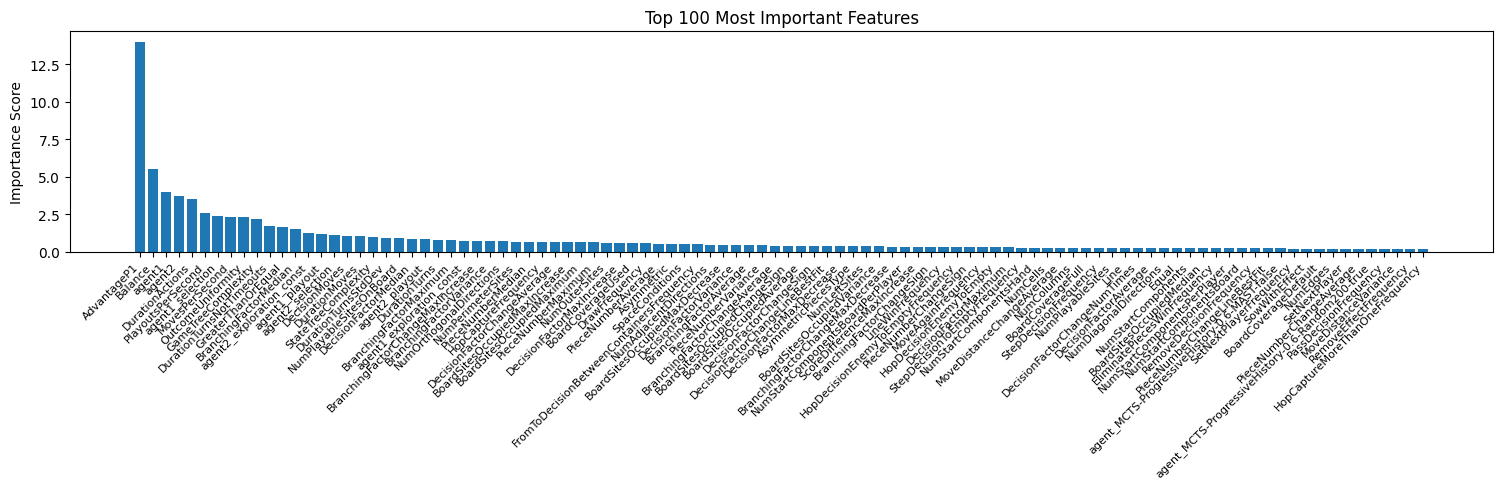

Fold 5 - RMSE: 0.42687406673325595
List of oof scores: [0.4283396029148786, 0.40361248197359584, 0.4124303727445388, 0.41414411377938143, 0.42687406673325595]
Average oof score: 0.41708012762913016


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4156
Score: 0.4426
Score: 0.4242
Score: 0.4371
Score: 0.4059
Average CV1 Score: 0.4251

CV2 OOF Scores:
Score: 0.4113
Score: 0.3995
Score: 0.4244
Score: 0.4393
Score: 0.4238
Average CV2 Score: 0.4197

CV3 OOF Scores:
Score: 0.4283
Score: 0.4036
Score: 0.4124
Score: 0.4141
Score: 0.4269
Average CV3 Score: 0.4171


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

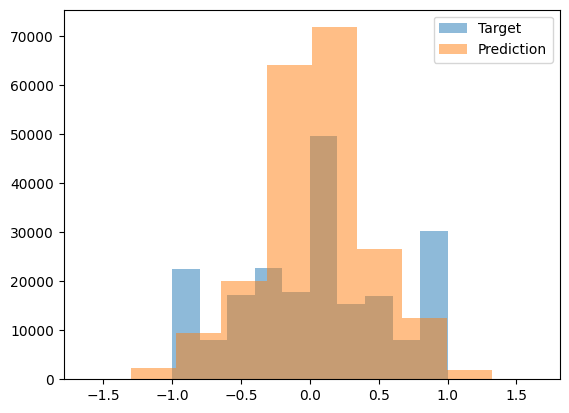

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.132371       │
│ 233235 ┆ -0.151979      │
│ 233236 ┆ -0.00422       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***